# PE4MOVE Data Analysis

This notebook analyzes the PE4MOVE dataset containing Physical Activity results and related parameters.

## Research Questions
- Was the PE4MOVE program successful?
- Which parameters influence the success of the study?
- What kind of children could improve the most from the program?

## Data Exploration

We'll start by loading the dataset and performing exploratory data analysis (EDA) to understand:
1. **Dataset structure**: Number of rows, columns, and data types
2. **Data quality**: Missing values, duplicates, and outliers
3. **Statistical overview**: Descriptive statistics for key variables
4. **Variable relationships**: Correlations and patterns in the data

This exploration will help us understand the data before addressing our research questions about the PE4MOVE program's effectiveness.

### 1. Import Required Libraries

First, we'll import all necessary libraries for data analysis and visualization:
- **pandas**: For data manipulation and analysis
- **numpy**: For numerical operations
- **matplotlib & seaborn**: For creating visualizations
- **scipy**: For statistical tests

In [2]:
# Import required libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")


### 2. Load Dataset and Variable Legends

We'll load both the main PE4MOVE dataset and the legends file to understand variable meanings and coding schemes.
This dataset contains information about children who participated in the PE4MOVE program, including their physical measurements and 6MWT results before and after the intervention.

In [3]:
# Configure display and plotting settings
df = pd.read_csv('data/PE4MOVE_6MWT.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3193 entries, 0 to 3192
Columns: 381 entries, Age to Dominant_Hand_T1
dtypes: float64(185), int64(188), object(8)
memory usage: 9.3+ MB


### 3. Dataset Overview and Quality Assessment

Let's examine the basic structure and quality of our dataset.

In [4]:
# === COMPREHENSIVE DATASET OVERVIEW ===

print("=== BASIC DATASET INFORMATION ===")
print(f"Participants: {len(df):,}")
print(f"Variables: {df.shape[1]}")
print(f"Age range: {df['Age'].min()} - {df['Age'].max()} years (Mean: {df['Age'].mean():.1f})")

# Gender distribution with proper coding (1=Male, 2=Female based on legends)
sex_counts = df['Sex'].value_counts().sort_index()
print(f"Gender: {sex_counts[1]} males ({sex_counts[1]/len(df)*100:.1f}%), {sex_counts[2]} females ({sex_counts[2]/len(df)*100:.1f}%)")

# Show first few rows
print(f"\n=== SAMPLE DATA ===")
display(df[['Age', 'Sex', 'MVPA_Frequency_T0', 'Weight_kg_T0', 'Height_cm_T0']].head())

=== BASIC DATASET INFORMATION ===
Participants: 3,193
Variables: 381
Age range: 11 - 18 years (Mean: 13.8)
Gender: 1535 males (48.1%), 1658 females (51.9%)

=== SAMPLE DATA ===


,Age,Sex,MVPA_Frequency_T0,Weight_kg_T0,Height_cm_T0
0,11,2,3,39,155
1,11,2,6,30,140
2,11,2,1,45,145
3,11,2,2,32,139
4,11,2,1,65,151


### 4. Key Data Visualizations

Now let's create visualizations to understand the most important patterns in our data.

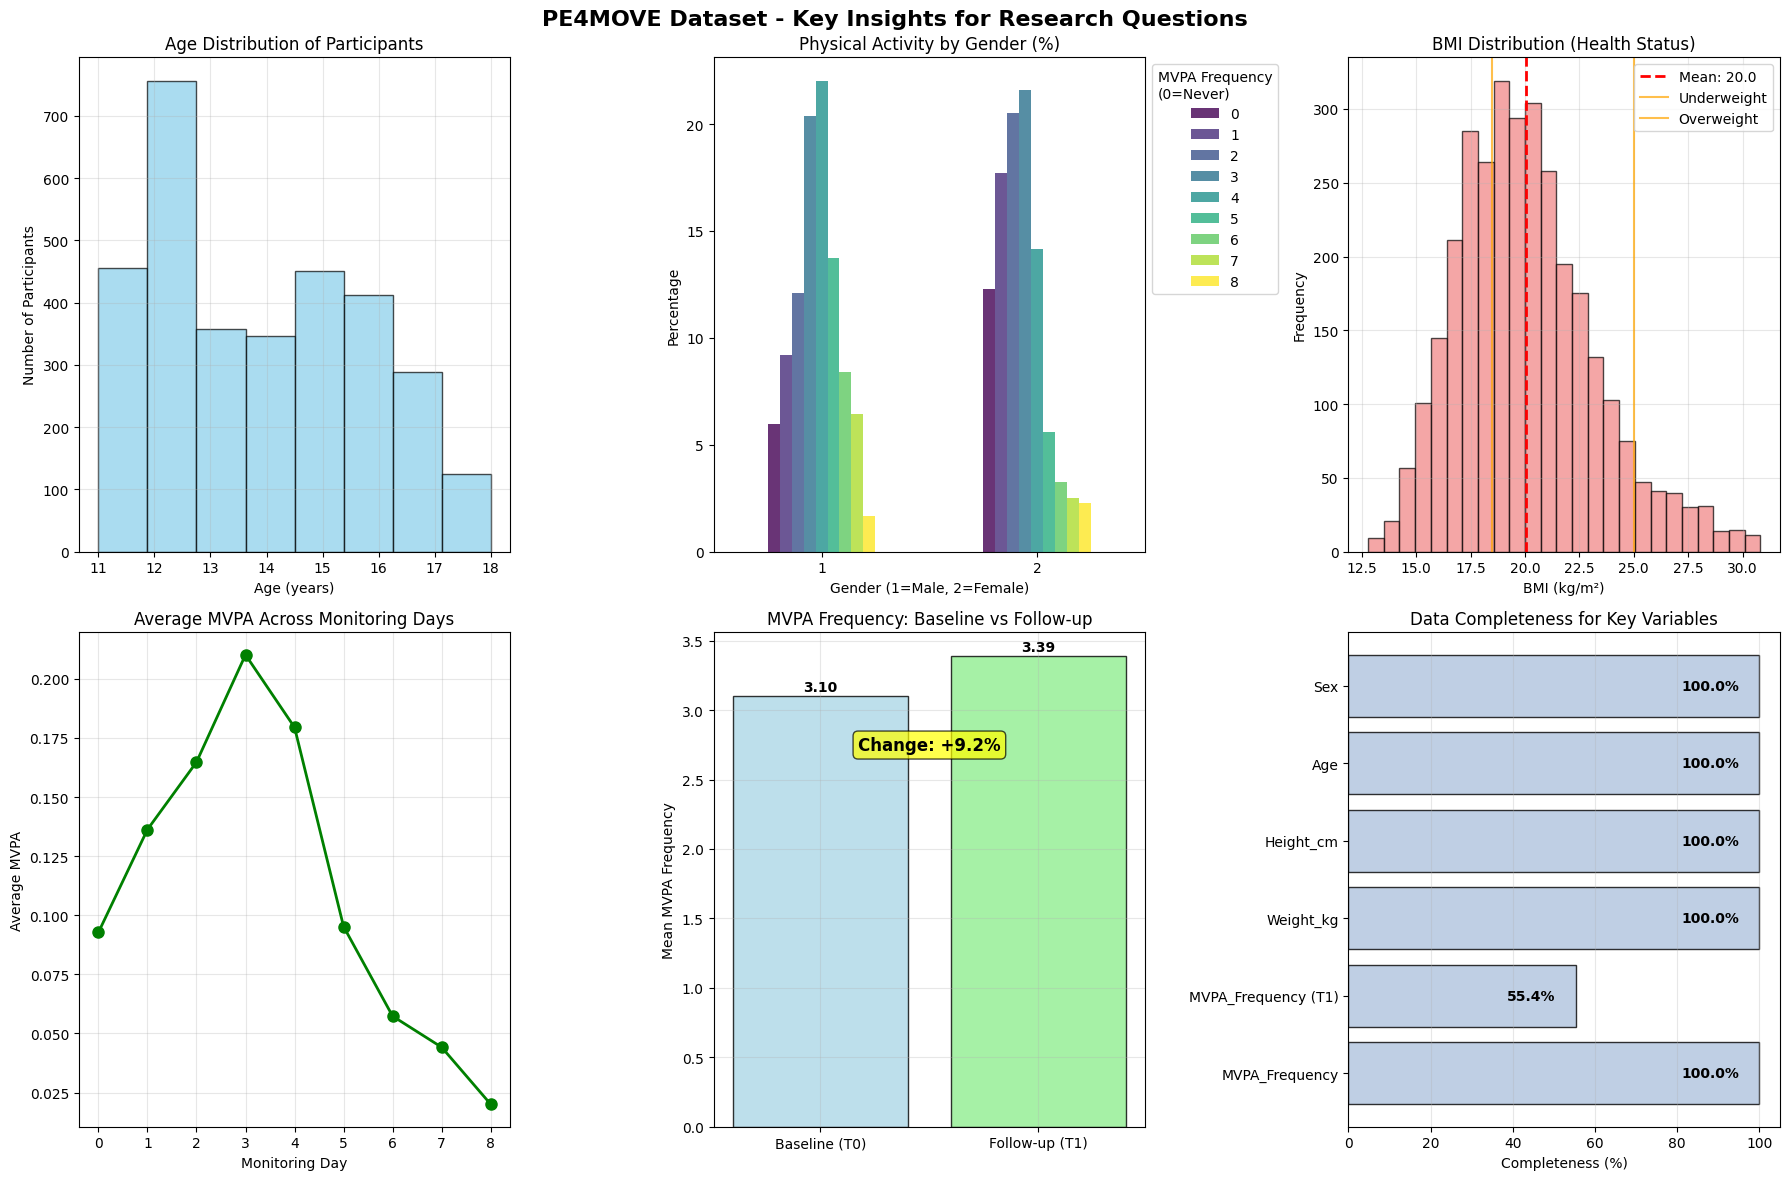

In [5]:
# === ESSENTIAL VISUALIZATIONS FOR PE4MOVE ANALYSIS ===

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('PE4MOVE Dataset - Key Insights for Research Questions', fontsize=16, fontweight='bold')

# 1. Age distribution of participants
axes[0,0].hist(df['Age'], bins=8, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Age Distribution of Participants')
axes[0,0].set_xlabel('Age (years)')
axes[0,0].set_ylabel('Number of Participants')
axes[0,0].grid(True, alpha=0.3)

# 2. Gender and Physical Activity Frequency
if 'MVPA_Frequency_T0' in df.columns:
    mvpa_gender = pd.crosstab(df['Sex'], df['MVPA_Frequency_T0'], normalize='index') * 100
    mvpa_gender.plot(kind='bar', ax=axes[0,1], colormap='viridis', alpha=0.8)
    axes[0,1].set_title('Physical Activity by Gender (%)')
    axes[0,1].set_xlabel('Gender (1=Male, 2=Female)')
    axes[0,1].set_ylabel('Percentage')
    axes[0,1].legend(title='MVPA Frequency\n(0=Never)', bbox_to_anchor=(1, 1))
    axes[0,1].tick_params(axis='x', rotation=0)

# 3. BMI Distribution (key health indicator)
if 'Weight_kg_T0' in df.columns and 'Height_cm_T0' in df.columns:
    height_m = df['Height_cm_T0'] / 100
    bmi = df['Weight_kg_T0'] / (height_m ** 2)
    bmi_clean = bmi[bmi <= 40]  # Remove extreme outliers
    
    axes[0,2].hist(bmi_clean, bins=25, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0,2].axvline(bmi_clean.mean(), color='red', linestyle='--', linewidth=2, 
                      label=f'Mean: {bmi_clean.mean():.1f}')
    axes[0,2].axvline(18.5, color='orange', linestyle='-', alpha=0.7, label='Underweight')
    axes[0,2].axvline(25, color='orange', linestyle='-', alpha=0.7, label='Overweight')
    axes[0,2].set_title('BMI Distribution (Health Status)')
    axes[0,2].set_xlabel('BMI (kg/m²)')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)

# 4. Physical Activity Patterns Over Days
mvpa_day_cols = [col for col in df.columns if 'MVPA_d' in col and col[-1].isdigit()]
if mvpa_day_cols:
    mvpa_means = df[mvpa_day_cols].mean()
    days = [col.split('_d')[1] for col in mvpa_day_cols]
    axes[1,0].plot(days, mvpa_means.values, marker='o', linewidth=2, markersize=8, color='green')
    axes[1,0].set_title('Average MVPA Across Monitoring Days')
    axes[1,0].set_xlabel('Monitoring Day')
    axes[1,0].set_ylabel('Average MVPA')
    axes[1,0].grid(True, alpha=0.3)

# 5. Intervention Effect Preview (T0 vs T1 comparison)
if 'MVPA_Frequency_T0' in df.columns and 'MVPA_Frequency_T1' in df.columns:
    # Compare baseline vs follow-up MVPA frequency
    t0_mean = df['MVPA_Frequency_T0'].mean()
    t1_mean = df['MVPA_Frequency_T1'].mean()
    
    comparison_data = [t0_mean, t1_mean]
    comparison_labels = ['Baseline (T0)', 'Follow-up (T1)']
    
    bars = axes[1,1].bar(comparison_labels, comparison_data, 
                        color=['lightblue', 'lightgreen'], alpha=0.8, edgecolor='black')
    axes[1,1].set_title('MVPA Frequency: Baseline vs Follow-up')
    axes[1,1].set_ylabel('Mean MVPA Frequency')
    
    # Add value labels on bars
    for bar, value in zip(bars, comparison_data):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # Calculate and show change
    change = ((t1_mean - t0_mean) / t0_mean) * 100 if t0_mean > 0 else 0
    axes[1,1].text(0.5, max(comparison_data) * 0.8, 
                  f'Change: {change:+.1f}%', 
                  ha='center', fontsize=12, fontweight='bold',
                  bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    axes[1,1].grid(True, alpha=0.3)

# 6. Data Completeness for Key Variables (important for analysis planning)
key_vars = ['MVPA_Frequency_T0', 'MVPA_Frequency_T1', 'Weight_kg_T0', 'Height_cm_T0', 'Age', 'Sex']
available_vars = [var for var in key_vars if var in df.columns]

if available_vars:
    completeness = [(df[var].notna().sum() / len(df)) * 100 for var in available_vars]
    
    bars = axes[1,2].barh(range(len(available_vars)), completeness, 
                         color='lightsteelblue', alpha=0.8, edgecolor='black')
    axes[1,2].set_yticks(range(len(available_vars)))
    axes[1,2].set_yticklabels([var.replace('_T0', '').replace('_T1', ' (T1)') 
                              for var in available_vars])
    axes[1,2].set_title('Data Completeness for Key Variables')
    axes[1,2].set_xlabel('Completeness (%)')
    
    # Add percentage labels
    for i, (bar, pct) in enumerate(zip(bars, completeness)):
        axes[1,2].text(pct - 5, bar.get_y() + bar.get_height()/2, 
                      f'{pct:.1f}%', ha='right', va='center', fontweight='bold')
    
    axes[1,2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

Comment:
- BMI Under-/Overweight thresholds are not fixed values for children/adolescents use WHO definition with percentiles
- instead of Male/Female use Boys/Girls

## Data Preparation



### 1. split dataset

split the dataset according to intervention and control group

In [6]:
# Check if Group_Final column exists
if 'Group_Final' in df.columns:
    
    # Check unique values and their counts
    group_counts = df['Group_Final'].value_counts()
    print(f"\nGroup Distribution:")
    print(group_counts)
    
    # Display unique values
    print(f"\nUnique group values: {sorted(df['Group_Final'].dropna().unique())}")
    


Group Distribution:
Group_Final
A    2095
B    1098
Name: count, dtype: int64

Unique group values: ['A', 'B']


In [7]:
# Compare T0 to T1 changes between groups for key variables
if 'MVPA_Frequency_T0' in df.columns and 'MVPA_Frequency_T1' in df.columns:
    
    # Calculate PAIRED mean MVPA for each group at T0 and T1
    for group in ['A', 'B']:
        group_data = df[df['Group_Final'] == group]
        
        # Use only paired data (participants with both T0 and T1)
        paired_mask = group_data['MVPA_Frequency_T0'].notna() & group_data['MVPA_Frequency_T1'].notna()
        paired_data = group_data[paired_mask]
        
        t0_mean = paired_data['MVPA_Frequency_T0'].mean()
        t1_mean = paired_data['MVPA_Frequency_T1'].mean()
        change = t1_mean - t0_mean
        change_pct = (change / t0_mean * 100) if t0_mean > 0 else 0
        
        n_total = len(group_data)
        n_paired = paired_mask.sum()
    
    # Determine intervention group (the one with more improvement) using paired data
    group_a_data = df[df['Group_Final'] == 'A']
    group_b_data = df[df['Group_Final'] == 'B']
    
    # Calculate paired changes for both groups
    a_paired_mask = group_a_data['MVPA_Frequency_T0'].notna() & group_a_data['MVPA_Frequency_T1'].notna()
    a_paired = group_a_data[a_paired_mask]
    a_change = a_paired['MVPA_Frequency_T1'].mean() - a_paired['MVPA_Frequency_T0'].mean()
    
    b_paired_mask = group_b_data['MVPA_Frequency_T0'].notna() & group_b_data['MVPA_Frequency_T1'].notna()
    b_paired = group_b_data[b_paired_mask]
    b_change = b_paired['MVPA_Frequency_T1'].mean() - b_paired['MVPA_Frequency_T0'].mean()
    
    if abs(a_change) > abs(b_change):
        intervention_group = 'A'
        control_group = 'B'
    else:
        intervention_group = 'B'
        control_group = 'A'
    

# === CREATE INTERVENTION AND CONTROL SUBSETS ===
print("\n" + "="*70)
print("CREATING DATASET SUBSETS")
print("="*70)

# Create the two subsets
# Note: Assigning based on pattern analysis - verify with study docs
df_intervention = df[df['Group_Final'] == intervention_group].copy()
df_control = df[df['Group_Final'] == control_group].copy()

print(f"\n Created intervention dataset: 'df_intervention'")
print(f"   • Group: {intervention_group}")
print(f"   • Participants: {len(df_control):,}")
print(f"   • Percentage: {len(df_control)/len(df)*100:.1f}%")

print(f"\n Created control dataset: 'df_control'")
print(f"   • Group: {control_group}")
print(f"   • Participants: {len(df_control):,}")
print(f"   • Percentage: {len(df_control)/len(df)*100:.1f}%")



CREATING DATASET SUBSETS

 Created intervention dataset: 'df_intervention'
   • Group: A
   • Participants: 1,098
   • Percentage: 34.4%

 Created control dataset: 'df_control'
   • Group: B
   • Participants: 1,098
   • Percentage: 34.4%


MVPA FREQUENCY DISTRIBUTION: T0 vs T1, Intervention vs Control

Data Overview:
Total participants: 3,193
Intervention group (A): 2,095
Control group (B): 1,098

MVPA_Frequency_T0:
  Missing values: 0 (0.0%)
  Value = 8 (prefer not to say): 64 (2.0%)

MVPA_Frequency_T1:
  Missing values: 1,423 (44.6%)
  Value = 8 (prefer not to say): 27 (0.8%)


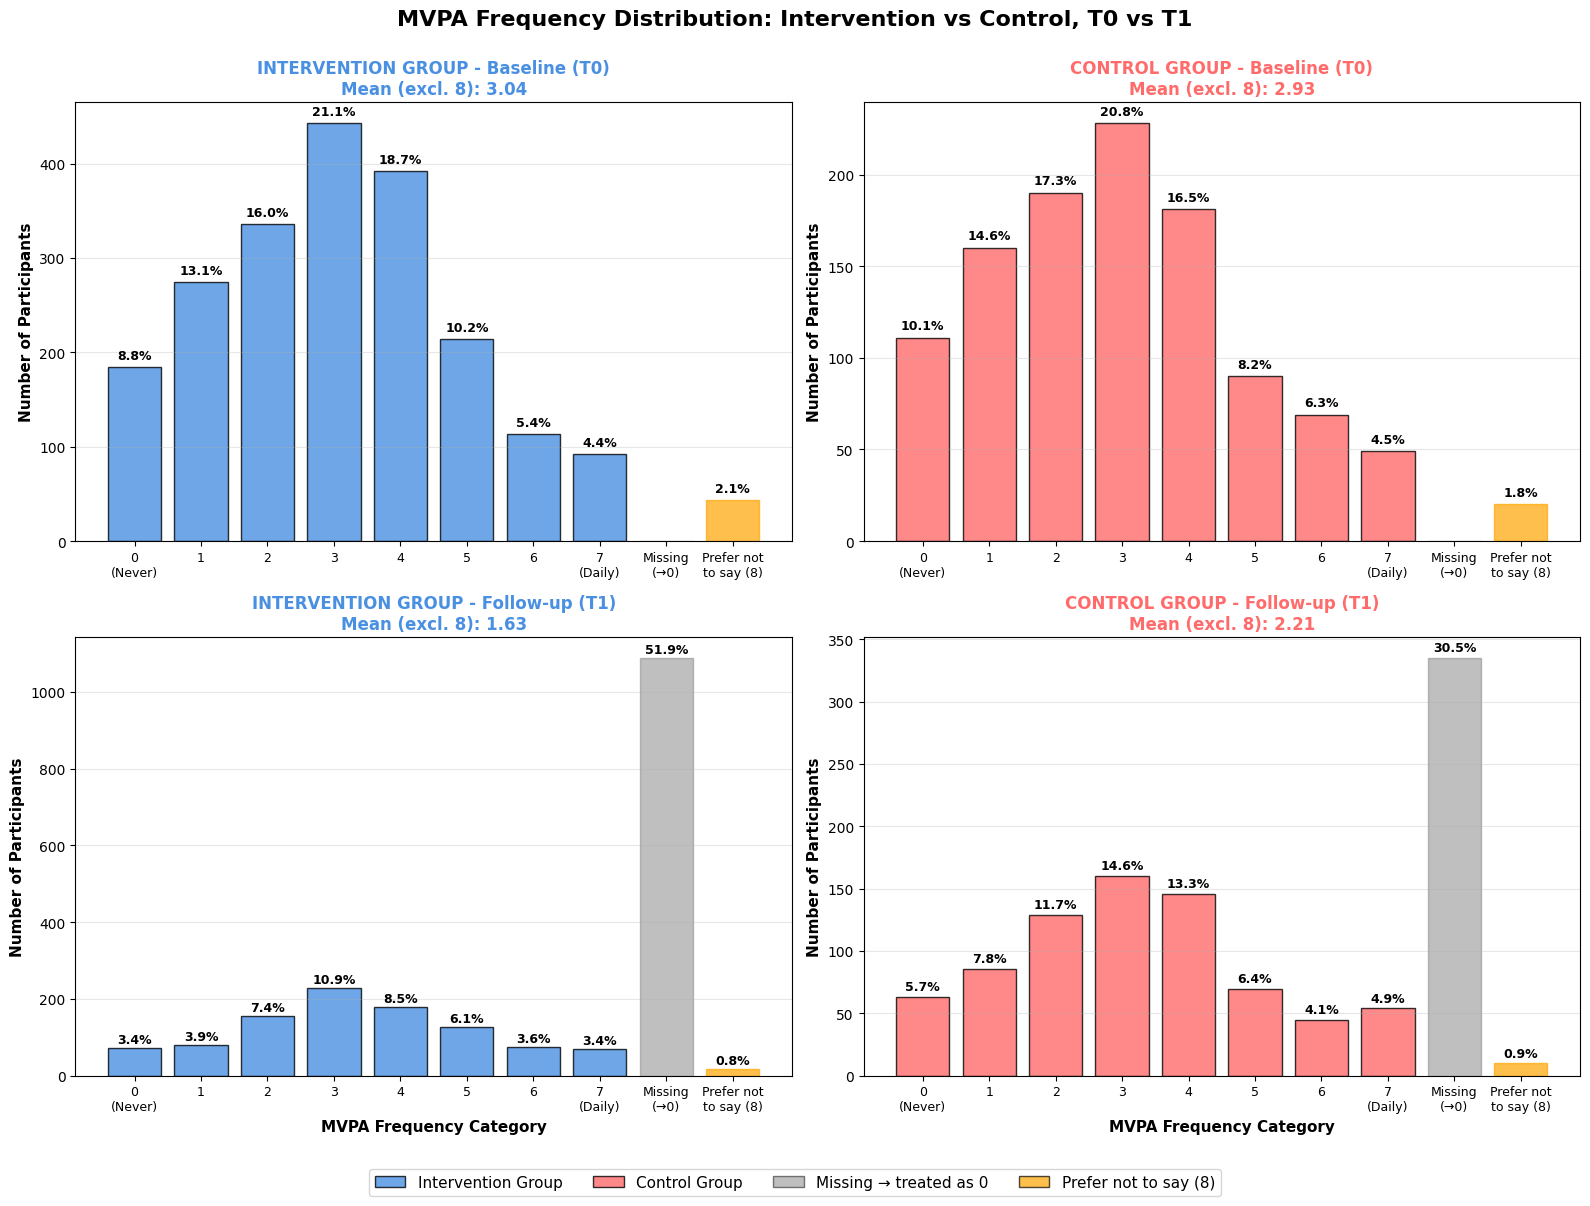

In [8]:
# === MVPA FREQUENCY DISTRIBUTION ANALYSIS ===
print("="*70)
print("MVPA FREQUENCY DISTRIBUTION: T0 vs T1, Intervention vs Control")
print("="*70)

# Prepare data with special handling for missing values and value 8
# Missing values → 0, Value 8 → "Prefer not to say"

# Create working copies
mvpa_vars = ['MVPA_Frequency_T0', 'MVPA_Frequency_T1']

# Check data availability
print(f"\nData Overview:")
print(f"Total participants: {len(df):,}")
print(f"Intervention group (A): {len(df_intervention):,}")
print(f"Control group (B): {len(df_control):,}")

for var in mvpa_vars:
    if var in df.columns:
        missing = df[var].isna().sum()
        value_8 = (df[var] == 8).sum()
        print(f"\n{var}:")
        print(f"  Missing values: {missing:,} ({missing/len(df)*100:.1f}%)")
        print(f"  Value = 8 (prefer not to say): {value_8:,} ({value_8/len(df)*100:.1f}%)")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('MVPA Frequency Distribution: Intervention vs Control, T0 vs T1', 
             fontsize=16, fontweight='bold')

# Define MVPA frequency labels (0-7 scale + special categories)
mvpa_labels = ['0\n(Never)', '1', '2', '3', '4', '5', '6', '7\n(Daily)', 
               'Missing\n(→0)', 'Prefer not\nto say (8)']

# Color scheme
colors_intervention = '#4A90E2'  # Blue
colors_control = '#FF6B6B'       # Red

# Function to prepare MVPA data with special handling
def prepare_mvpa_data(data, var_name):
    """
    Prepare MVPA data:
    - Missing values → category 8 (will be treated as 0 in analysis)
    - Value 8 → category 9 (prefer not to say)
    - Values 0-7 → keep as is
    """
    result = data[var_name].copy()
    
    # Track original categories
    categories = {
        'valid_0_7': (result >= 0) & (result <= 7),
        'missing': result.isna(),
        'prefer_not_say': result == 8
    }
    
    # Create categorical version for plotting
    plot_data = result.copy()
    plot_data = plot_data.fillna(8)  # Missing → 8
    plot_data = plot_data.replace(8, 9)  # Original 8 → 9
    
    # For statistics, treat differently
    stats_data = result.copy()
    stats_data = stats_data.fillna(0)  # Missing → 0 for statistics
    stats_data = stats_data.replace(8, np.nan)  # Value 8 → NaN (exclude from statistics)
    
    return plot_data, stats_data, categories

# ==================== SUBPLOT 1: INTERVENTION GROUP - T0 ====================
ax1 = axes[0, 0]

if 'MVPA_Frequency_T0' in df_intervention.columns:
    plot_data, stats_data, categories = prepare_mvpa_data(df_intervention, 'MVPA_Frequency_T0')
    
    # Count frequencies for each category (0-7, missing, prefer not to say)
    counts = []
    for i in range(8):  # 0-7
        counts.append((plot_data == i).sum())
    counts.append(categories['missing'].sum())  # Missing
    counts.append(categories['prefer_not_say'].sum())  # Prefer not to say
    
    # Create bar plot
    x_pos = np.arange(len(counts))
    bars = ax1.bar(x_pos, counts, color=colors_intervention, alpha=0.8, edgecolor='black')
    
    # Highlight special categories
    bars[8].set_color('gray')  # Missing
    bars[8].set_alpha(0.5)
    bars[9].set_color('orange')  # Prefer not to say
    bars[9].set_alpha(0.7)
    
    # Add percentage labels
    for i, (bar, count) in enumerate(zip(bars, counts)):
        if count > 0:
            pct = count / len(df_intervention) * 100
            ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 5,
                    f'{pct:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(mvpa_labels, fontsize=9)
    ax1.set_ylabel('Number of Participants', fontsize=11, fontweight='bold')
    ax1.set_title(f'INTERVENTION GROUP - Baseline (T0)\nMean (excl. 8): {stats_data.mean():.2f}', 
                 fontsize=12, fontweight='bold', color=colors_intervention)
    ax1.grid(True, alpha=0.3, axis='y')

# ==================== SUBPLOT 2: CONTROL GROUP - T0 ====================
ax2 = axes[0, 1]

if 'MVPA_Frequency_T0' in df_control.columns:
    plot_data, stats_data, categories = prepare_mvpa_data(df_control, 'MVPA_Frequency_T0')
    
    # Count frequencies
    counts = []
    for i in range(8):  # 0-7
        counts.append((plot_data == i).sum())
    counts.append(categories['missing'].sum())  # Missing
    counts.append(categories['prefer_not_say'].sum())  # Prefer not to say
    
    # Create bar plot
    x_pos = np.arange(len(counts))
    bars = ax2.bar(x_pos, counts, color=colors_control, alpha=0.8, edgecolor='black')
    
    # Highlight special categories
    bars[8].set_color('gray')
    bars[8].set_alpha(0.5)
    bars[9].set_color('orange')
    bars[9].set_alpha(0.7)
    
    # Add percentage labels
    for i, (bar, count) in enumerate(zip(bars, counts)):
        if count > 0:
            pct = count / len(df_control) * 100
            ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 3,
                    f'{pct:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(mvpa_labels, fontsize=9)
    ax2.set_ylabel('Number of Participants', fontsize=11, fontweight='bold')
    ax2.set_title(f'CONTROL GROUP - Baseline (T0)\nMean (excl. 8): {stats_data.mean():.2f}', 
                 fontsize=12, fontweight='bold', color=colors_control)
    ax2.grid(True, alpha=0.3, axis='y')

# ==================== SUBPLOT 3: INTERVENTION GROUP - T1 ====================
ax3 = axes[1, 0]

if 'MVPA_Frequency_T1' in df_intervention.columns:
    plot_data, stats_data, categories = prepare_mvpa_data(df_intervention, 'MVPA_Frequency_T1')
    
    # Count frequencies
    counts = []
    for i in range(8):  # 0-7
        counts.append((plot_data == i).sum())
    counts.append(categories['missing'].sum())  # Missing
    counts.append(categories['prefer_not_say'].sum())  # Prefer not to say
    
    # Create bar plot
    x_pos = np.arange(len(counts))
    bars = ax3.bar(x_pos, counts, color=colors_intervention, alpha=0.8, edgecolor='black')
    
    # Highlight special categories
    bars[8].set_color('gray')
    bars[8].set_alpha(0.5)
    bars[9].set_color('orange')
    bars[9].set_alpha(0.7)
    
    # Add percentage labels
    for i, (bar, count) in enumerate(zip(bars, counts)):
        if count > 0:
            pct = count / len(df_intervention) * 100
            ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 5,
                    f'{pct:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(mvpa_labels, fontsize=9)
    ax3.set_xlabel('MVPA Frequency Category', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Number of Participants', fontsize=11, fontweight='bold')
    ax3.set_title(f'INTERVENTION GROUP - Follow-up (T1)\nMean (excl. 8): {stats_data.mean():.2f}', 
                 fontsize=12, fontweight='bold', color=colors_intervention)
    ax3.grid(True, alpha=0.3, axis='y')

# ==================== SUBPLOT 4: CONTROL GROUP - T1 ====================
ax4 = axes[1, 1]

if 'MVPA_Frequency_T1' in df_control.columns:
    plot_data, stats_data, categories = prepare_mvpa_data(df_control, 'MVPA_Frequency_T1')
    
    # Count frequencies
    counts = []
    for i in range(8):  # 0-7
        counts.append((plot_data == i).sum())
    counts.append(categories['missing'].sum())  # Missing
    counts.append(categories['prefer_not_say'].sum())  # Prefer not to say
    
    # Create bar plot
    x_pos = np.arange(len(counts))
    bars = ax4.bar(x_pos, counts, color=colors_control, alpha=0.8, edgecolor='black')
    
    # Highlight special categories
    bars[8].set_color('gray')
    bars[8].set_alpha(0.5)
    bars[9].set_color('orange')
    bars[9].set_alpha(0.7)
    
    # Add percentage labels
    for i, (bar, count) in enumerate(zip(bars, counts)):
        if count > 0:
            pct = count / len(df_control) * 100
            ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 3,
                    f'{pct:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(mvpa_labels, fontsize=9)
    ax4.set_xlabel('MVPA Frequency Category', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Number of Participants', fontsize=11, fontweight='bold')
    ax4.set_title(f'CONTROL GROUP - Follow-up (T1)\nMean (excl. 8): {stats_data.mean():.2f}', 
                 fontsize=12, fontweight='bold', color=colors_control)
    ax4.grid(True, alpha=0.3, axis='y')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors_intervention, alpha=0.8, edgecolor='black', label='Intervention Group'),
    Patch(facecolor=colors_control, alpha=0.8, edgecolor='black', label='Control Group'),
    Patch(facecolor='gray', alpha=0.5, edgecolor='black', label='Missing → treated as 0'),
    Patch(facecolor='orange', alpha=0.7, edgecolor='black', label='Prefer not to say (8)')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), 
          ncol=4, fontsize=11, frameon=True)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()


In [9]:
# === CREATE FILTERED INTERVENTION DATASET (T1 COMPLETE) ===
print("="*70)
print("CREATING FILTERED INTERVENTION DATASET")
print("="*70)

print(f"\n📊 Original intervention dataset:")
print(f"   Total participants: {len(df_intervention):,}")
print(f"   MVPA_Frequency_T1 missing: {df_intervention['MVPA_Frequency_T1'].isna().sum():,}")
print(f"   MVPA_Frequency_T1 available: {df_intervention['MVPA_Frequency_T1'].notna().sum():,}")

# Create new dataset excluding rows with missing MVPA_Frequency_T1
df_intervention_complete_T1 = df_intervention[df_intervention['MVPA_Frequency_T1'].notna()].copy()

print(f"\n✅ New filtered dataset: 'df_intervention_complete_T1'")
print(f"   Participants with T1 data: {len(df_intervention_complete_T1):,}")
print(f"   Rows removed: {len(df_intervention) - len(df_intervention_complete_T1):,}")
print(f"   Retention rate: {len(df_intervention_complete_T1)/len(df_intervention)*100:.1f}%")

# Additional data quality check
print(f"\n📋 Data quality in filtered dataset:")
print(f"   MVPA_Frequency_T0 available: {df_intervention_complete_T1['MVPA_Frequency_T0'].notna().sum():,}")
print(f"   Both T0 and T1 available: {(df_intervention_complete_T1['MVPA_Frequency_T0'].notna() & df_intervention_complete_T1['MVPA_Frequency_T1'].notna()).sum():,}")

# Show T1 value distribution
print(f"\n📈 MVPA_Frequency_T1 distribution in filtered dataset:")
t1_counts = df_intervention_complete_T1['MVPA_Frequency_T1'].value_counts().sort_index()
for value, count in t1_counts.items():
    pct = count / len(df_intervention_complete_T1) * 100
    print(f"   Value {value}: {count:,} ({pct:.1f}%)")

# === REMOVE VARIABLES WITH >80% MISSING DATA ===
print("\n" + "="*70)
print("REMOVING VARIABLES WITH >80% MISSING DATA")
print("="*70)

# Calculate missing percentage for each variable
missing_pct = (df_intervention_complete_T1.isna().sum() / len(df_intervention_complete_T1) * 100).sort_values(ascending=False)

# Identify columns to drop (>80% missing)
cols_to_drop = missing_pct[missing_pct > 80].index.tolist()

print(f"\n🔍 Variables with >80% missing data: {len(cols_to_drop)}")
if len(cols_to_drop) > 0:
    print(f"\n   Top 10 variables with highest missing %:")
    for col in cols_to_drop[:10]:
        print(f"   • {col:<40} {missing_pct[col]:.1f}% missing")
    if len(cols_to_drop) > 10:
        print(f"   ... and {len(cols_to_drop) - 10} more variables")

# Store original shape
original_cols = df_intervention_complete_T1.shape[1]

# Drop columns with >80% missing
df_intervention_complete_T1 = df_intervention_complete_T1.drop(columns=cols_to_drop)

print(f"\n✅ Dataset after removing high-missing variables:")
print(f"   Original variables: {original_cols}")
print(f"   Variables removed: {len(cols_to_drop)}")
print(f"   Remaining variables: {df_intervention_complete_T1.shape[1]}")
print(f"   Participants: {len(df_intervention_complete_T1):,} (unchanged)")

# Show remaining data quality
remaining_missing = (df_intervention_complete_T1.isna().sum() / len(df_intervention_complete_T1) * 100)
print(f"\n📊 Remaining data quality:")
print(f"   Variables with 0% missing: {(remaining_missing == 0).sum()}")
print(f"   Variables with 1-20% missing: {((remaining_missing > 0) & (remaining_missing <= 20)).sum()}")
print(f"   Variables with 21-50% missing: {((remaining_missing > 20) & (remaining_missing <= 50)).sum()}")
print(f"   Variables with 51-80% missing: {((remaining_missing > 50) & (remaining_missing <= 80)).sum()}")

print("\n" + "="*70)

# === REMOVE SPECIFIC ATTRIBUTE PATTERNS ===
print("="*70)
print("REMOVING SPECIFIC ATTRIBUTE PATTERNS")
print("="*70)

# Define patterns to remove
patterns_to_remove = [
    'd0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8',  # Daily patterns
    'Climate', 'Need', 'Achiev', 'Enjoy', 'Intention', 'Perc',  # Questionnaire items
    'Attitude', 'Support', 'Vitality',  # More questionnaire items
    'Principal_barrier', 'Barrier', 'SES', 'ActionPlan',  # Barrier and SES items
    'Birth_Italy', 'School_grade', 'Sport_LastYear', 'Influence_Test_YesNo', 'Dominant_Hand', 'Sport_UpperSecondary'  # Demographic/other non-essential
]

# Find columns matching any of the patterns
cols_to_remove = []
for col in df_intervention_complete_T1.columns:
    for pattern in patterns_to_remove:
        if pattern in col:
            cols_to_remove.append(col)
            break  # Only add once even if multiple patterns match

# Remove duplicates (in case a column matched multiple patterns)
cols_to_remove = list(set(cols_to_remove))

print(f"\n🔍 Found {len(cols_to_remove)} columns matching the removal patterns:")

# Group by pattern for reporting
if len(cols_to_remove) > 0:
    for pattern in patterns_to_remove:
        matching_cols = [col for col in cols_to_remove if pattern in col]
        if matching_cols:
            print(f"\n   Pattern '{pattern}': {len(matching_cols)} columns")
            # Show first 3 examples
            for col in matching_cols[:3]:
                print(f"      • {col}")
            if len(matching_cols) > 3:
                print(f"      ... and {len(matching_cols) - 3} more")

# Store shape before removal
cols_before = df_intervention_complete_T1.shape[1]

# Remove the columns
df_intervention_complete_T1 = df_intervention_complete_T1.drop(columns=cols_to_remove, errors='ignore')

print(f"\n✅ Columns removed: {len(cols_to_remove)}")
print(f"   Variables before: {cols_before}")
print(f"   Variables after: {df_intervention_complete_T1.shape[1]}")
print(f"   Participants: {len(df_intervention_complete_T1):,} (unchanged)")

print("\n" + "="*70)

CREATING FILTERED INTERVENTION DATASET

📊 Original intervention dataset:
   Total participants: 2,095
   MVPA_Frequency_T1 missing: 1,088
   MVPA_Frequency_T1 available: 1,007

✅ New filtered dataset: 'df_intervention_complete_T1'
   Participants with T1 data: 1,007
   Rows removed: 1,088
   Retention rate: 48.1%

📋 Data quality in filtered dataset:
   MVPA_Frequency_T0 available: 1,007
   Both T0 and T1 available: 1,007

📈 MVPA_Frequency_T1 distribution in filtered dataset:
   Value 0.0: 72 (7.1%)
   Value 1.0: 81 (8.0%)
   Value 2.0: 156 (15.5%)
   Value 3.0: 229 (22.7%)
   Value 4.0: 178 (17.7%)
   Value 5.0: 128 (12.7%)
   Value 6.0: 75 (7.4%)
   Value 7.0: 71 (7.1%)
   Value 8.0: 17 (1.7%)

REMOVING VARIABLES WITH >80% MISSING DATA

🔍 Variables with >80% missing data: 16

   Top 10 variables with highest missing %:
   • Principal_barrier_type_T1                100.0% missing
   • Unnamed: 28                              100.0% missing
   • Influence_SixMW_T0                       

### RQ1: Was the PE4MOVE program successful?

Key Findings:

All Participants Have Baseline Data (T0)
- Group A: 2,095 with T0 data (100%)
- Group B: 1,098 with T0 data (100%)
- Total: 3,193 with T0 data

Follow-up Data (T1) Shows Attrition
- Group A: 1,007 with T1 data (51.9% dropout rate)
- Group B: 763 with T1 data (30.5% dropout rate)
- Total: 1,770 with T1 data

Important Observation:

The intervention group (Group A) had a much higher dropout rate (51.9%) compared to the control group (30.5%). This is a significant finding that should be considered in your analysis, as it may indicate:

- Implementation challenges in the intervention
- Participant burden was higher in the intervention group
- Potential selection bias (completers vs. dropouts may differ systematically)

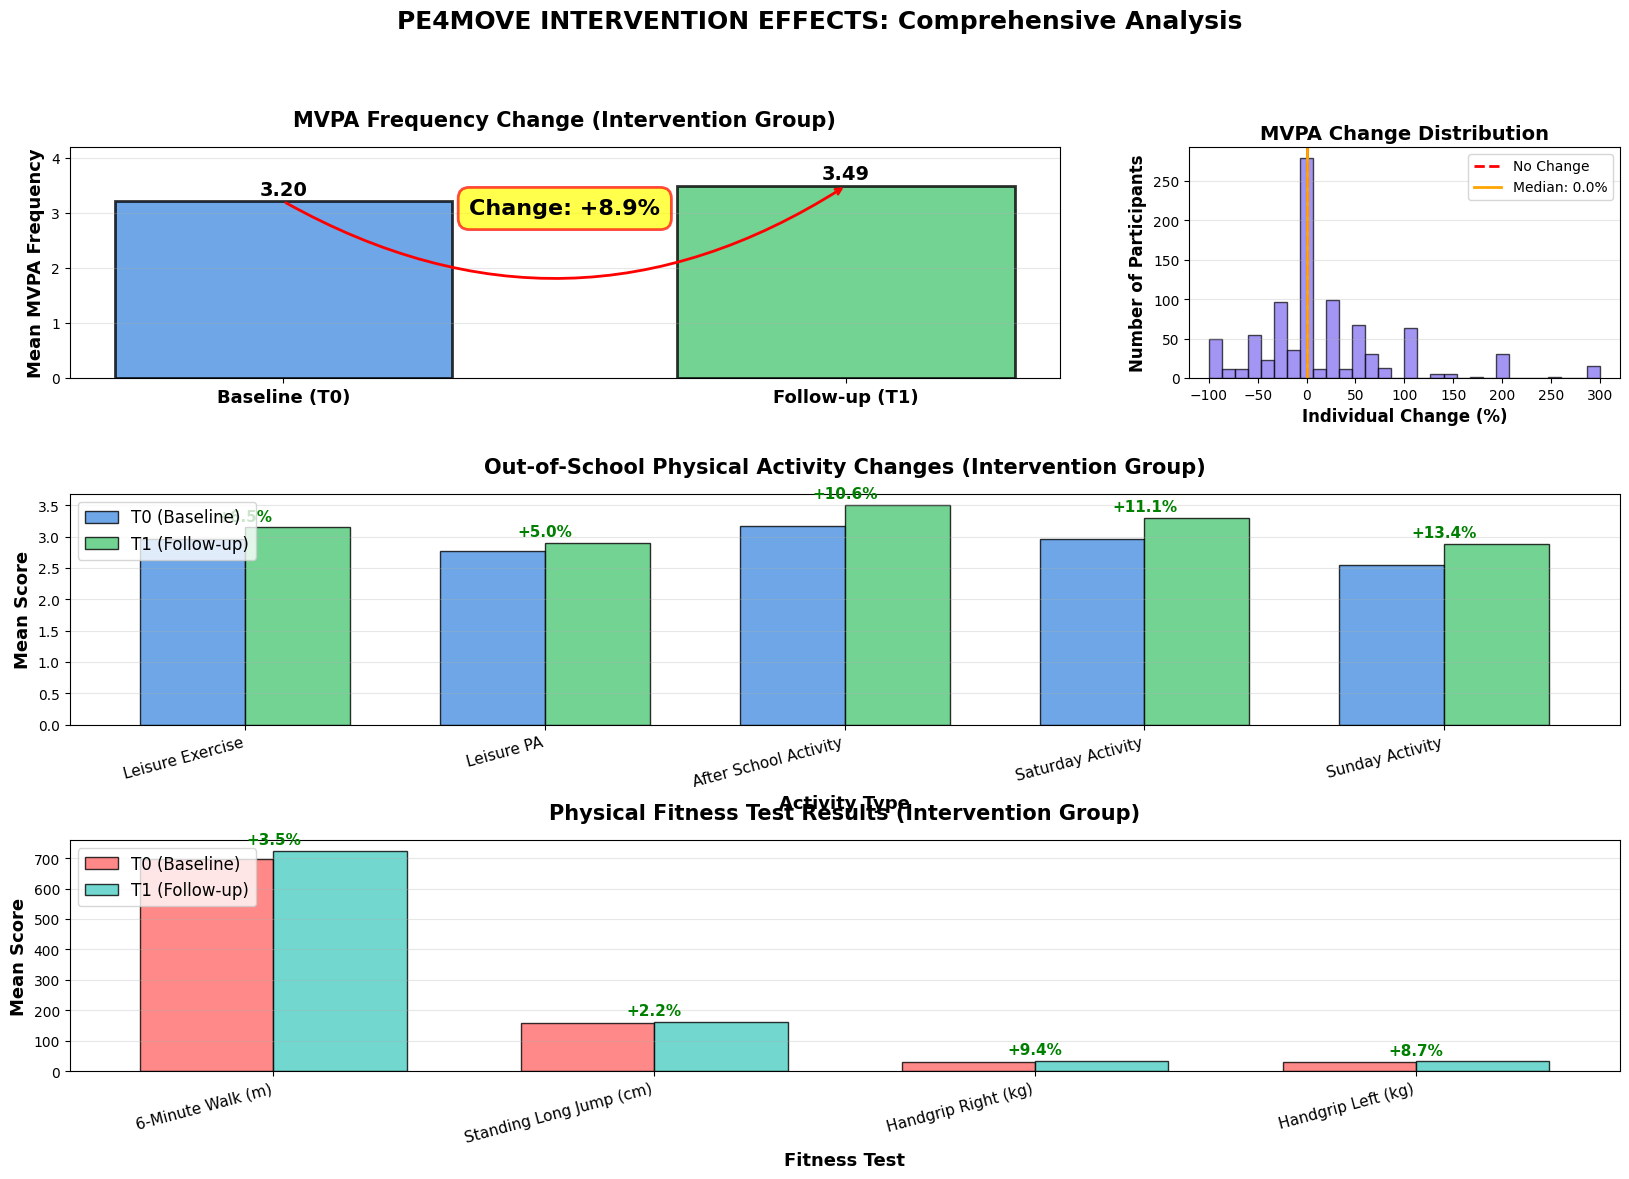


INTERVENTION EFFECTS SUMMARY

📊 MVPA FREQUENCY:
   Baseline (T0): 3.20
   Follow-up (T1): 3.49
   Relative Change: +8.9%
   Participants improved: 353 (38.6%)
   Participants declined: 282 (30.9%)

🏃 OUT-OF-SCHOOL PHYSICAL ACTIVITY:
   Leisure Exercise:
      T0 → T1: 2.95 → 3.14 (+6.5%)
   Leisure PA:
      T0 → T1: 2.76 → 2.90 (+5.0%)
   After School Activity:
      T0 → T1: 3.17 → 3.51 (+10.6%)
   Saturday Activity:
      T0 → T1: 2.97 → 3.30 (+11.1%)
   Sunday Activity:
      T0 → T1: 2.55 → 2.89 (+13.4%)

💪 PHYSICAL FITNESS TESTS:
   6-Minute Walk (m):
      T0 → T1: 699.0 → 723.3 (+3.5%)
   Standing Long Jump (cm):
      T0 → T1: 159.2 → 162.7 (+2.2%)
   Handgrip Right (kg):
      T0 → T1: 31.1 → 34.1 (+9.4%)
   Handgrip Left (kg):
      T0 → T1: 29.5 → 32.0 (+8.7%)



In [10]:
# === INTERVENTION EFFECT VISUALIZATION ===

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.5, wspace=0.3)

# ==================== 1. MVPA FREQUENCY ====================
ax1 = fig.add_subplot(gs[0, :2])

# Calculate relative change for MVPA Frequency
t0_mvpa = df_intervention['MVPA_Frequency_T0'].dropna()
t1_mvpa = df_intervention['MVPA_Frequency_T1'].dropna()

# Paired data only
paired_mask = df_intervention['MVPA_Frequency_T0'].notna() & df_intervention['MVPA_Frequency_T1'].notna()
t0_mvpa_paired = df_intervention.loc[paired_mask, 'MVPA_Frequency_T0']
t1_mvpa_paired = df_intervention.loc[paired_mask, 'MVPA_Frequency_T1']

mean_t0_mvpa = t0_mvpa_paired.mean()
mean_t1_mvpa = t1_mvpa_paired.mean()
relative_change_mvpa = ((mean_t1_mvpa - mean_t0_mvpa) / mean_t0_mvpa) * 100

# Create grouped bar chart
x_pos = [0, 1]
means = [mean_t0_mvpa, mean_t1_mvpa]
colors = ['#4A90E2', '#50C878']

bars = ax1.bar(x_pos, means, width=0.6, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, means)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{value:.2f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Add change annotation
ax1.annotate('', xy=(1, mean_t1_mvpa), xytext=(0, mean_t0_mvpa),
            arrowprops=dict(arrowstyle='->', lw=2, color='red', connectionstyle='arc3,rad=0.3'))
ax1.text(0.5, max(means) * 0.85, f'Change: +{relative_change_mvpa:.1f}%',
        ha='center', fontsize=16, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7, edgecolor='red', linewidth=2))

ax1.set_xticks(x_pos)
ax1.set_xticklabels(['Baseline (T0)', 'Follow-up (T1)'], fontsize=13, fontweight='bold')
ax1.set_ylabel('Mean MVPA Frequency', fontsize=13, fontweight='bold')
ax1.set_title('MVPA Frequency Change (Intervention Group)', fontsize=15, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, max(means) * 1.2)

# ==================== 2. MVPA FREQUENCY DISTRIBUTION ====================
ax2 = fig.add_subplot(gs[0, 2])

# Calculate individual changes (exclude division by zero)
mask_nonzero = t0_mvpa_paired > 0
individual_changes = ((t1_mvpa_paired[mask_nonzero] - t0_mvpa_paired[mask_nonzero]) / t0_mvpa_paired[mask_nonzero] * 100).dropna()
# Remove extreme outliers for better visualization
individual_changes = individual_changes[np.abs(individual_changes) < 500]

ax2.hist(individual_changes, bins=30, color='#7B68EE', alpha=0.7, edgecolor='black')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='No Change')
ax2.axvline(individual_changes.median(), color='orange', linestyle='-', linewidth=2, 
           label=f'Median: {individual_changes.median():.1f}%')

ax2.set_xlabel('Individual Change (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Participants', fontsize=12, fontweight='bold')
ax2.set_title('MVPA Change Distribution', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# ==================== 3. OUT-OF-SCHOOL PHYSICAL ACTIVITY ====================
ax3 = fig.add_subplot(gs[1, :])

# Identify out-of-school PA variables
leisure_vars = [
    ('Leisure_Exercise_T0', 'Leisure_Exercise_T1', 'Leisure Exercise'),
    ('Leisure_PA_T0', 'Leisure_PA_T1', 'Leisure PA'),
    ('YAP_out_after_T0', 'YAP_out_after_T1', 'After School Activity'),
    ('YAP_out_saturday_T0', 'YAP_out_saturday_T1', 'Saturday Activity'),
    ('YAP_out_sunday_T0', 'YAP_out_sunday_T1', 'Sunday Activity')
]

pa_labels = []
pa_changes = []
pa_t0_means = []
pa_t1_means = []

for t0_var, t1_var, label in leisure_vars:
    if t0_var in df_intervention.columns and t1_var in df_intervention.columns:
        mask = df_intervention[t0_var].notna() & df_intervention[t1_var].notna()
        if mask.sum() > 0:
            t0_mean = df_intervention.loc[mask, t0_var].mean()
            t1_mean = df_intervention.loc[mask, t1_var].mean()
            change_pct = ((t1_mean - t0_mean) / t0_mean * 100) if t0_mean > 0 else 0
            
            pa_labels.append(label)
            pa_changes.append(change_pct)
            pa_t0_means.append(t0_mean)
            pa_t1_means.append(t1_mean)

if pa_labels:
    x_pos = np.arange(len(pa_labels))
    width = 0.35
    
    bars1 = ax3.bar(x_pos - width/2, pa_t0_means, width, label='T0 (Baseline)', 
                   color='#4A90E2', alpha=0.8, edgecolor='black')
    bars2 = ax3.bar(x_pos + width/2, pa_t1_means, width, label='T1 (Follow-up)', 
                   color='#50C878', alpha=0.8, edgecolor='black')
    
    # Add change percentage on top
    for i, (t0, t1, change) in enumerate(zip(pa_t0_means, pa_t1_means, pa_changes)):
        max_height = max(t0, t1)
        color = 'green' if change > 0 else 'red'
        ax3.text(i, max_height + max(pa_t0_means + pa_t1_means) * 0.03, 
                f'{change:+.1f}%', ha='center', fontsize=11, 
                fontweight='bold', color=color)
    
    ax3.set_xlabel('Activity Type', fontsize=13, fontweight='bold')
    ax3.set_ylabel('Mean Score', fontsize=13, fontweight='bold')
    ax3.set_title('Out-of-School Physical Activity Changes (Intervention Group)', 
                 fontsize=15, fontweight='bold', pad=15)
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(pa_labels, rotation=15, ha='right', fontsize=11)
    ax3.legend(fontsize=12, loc='upper left')
    ax3.grid(True, alpha=0.3, axis='y')

# ==================== 4. PHYSICAL FITNESS TESTS ====================
ax4 = fig.add_subplot(gs[2, :])

# Identify fitness test variables
fitness_vars = [
    ('SixMW_T0', 'SixMW_T1', '6-Minute Walk (m)'),
    ('SLJ_T0', 'SLJ_T1', 'Standing Long Jump (cm)'),
    ('HG_Right_T0', 'HG_Right_T1', 'Handgrip Right (kg)'),
    ('HG_Left_T0', 'HG_Left_T1', 'Handgrip Left (kg)')
]

fitness_labels = []
fitness_changes = []
fitness_t0_means = []
fitness_t1_means = []

for t0_var, t1_var, label in fitness_vars:
    if t0_var in df_intervention.columns and t1_var in df_intervention.columns:
        mask = df_intervention[t0_var].notna() & df_intervention[t1_var].notna()
        if mask.sum() > 0:
            t0_mean = df_intervention.loc[mask, t0_var].mean()
            t1_mean = df_intervention.loc[mask, t1_var].mean()
            change_pct = ((t1_mean - t0_mean) / t0_mean * 100) if t0_mean > 0 else 0
            
            fitness_labels.append(label)
            fitness_changes.append(change_pct)
            fitness_t0_means.append(t0_mean)
            fitness_t1_means.append(t1_mean)

if fitness_labels:
    x_pos = np.arange(len(fitness_labels))
    width = 0.35
    
    bars1 = ax4.bar(x_pos - width/2, fitness_t0_means, width, label='T0 (Baseline)', 
                   color='#FF6B6B', alpha=0.8, edgecolor='black')
    bars2 = ax4.bar(x_pos + width/2, fitness_t1_means, width, label='T1 (Follow-up)', 
                   color='#4ECDC4', alpha=0.8, edgecolor='black')
    
    # Add change percentage on top
    for i, (t0, t1, change) in enumerate(zip(fitness_t0_means, fitness_t1_means, fitness_changes)):
        max_height = max(t0, t1)
        color = 'green' if change > 0 else 'red'
        ax4.text(i, max_height + max(fitness_t0_means + fitness_t1_means) * 0.03, 
                f'{change:+.1f}%', ha='center', fontsize=11, 
                fontweight='bold', color=color)
    
    ax4.set_xlabel('Fitness Test', fontsize=13, fontweight='bold')
    ax4.set_ylabel('Mean Score', fontsize=13, fontweight='bold')
    ax4.set_title('Physical Fitness Test Results (Intervention Group)', 
                 fontsize=15, fontweight='bold', pad=15)
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(fitness_labels, rotation=15, ha='right', fontsize=11)
    ax4.legend(fontsize=12, loc='upper left')
    ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('PE4MOVE INTERVENTION EFFECTS: Comprehensive Analysis', 
            fontsize=18, fontweight='bold', y=0.995)

plt.show()

# ==================== SUMMARY STATISTICS ====================
print("\n" + "="*70)
print("INTERVENTION EFFECTS SUMMARY")
print("="*70)

print(f"\n📊 MVPA FREQUENCY:")
print(f"   Baseline (T0): {mean_t0_mvpa:.2f}")
print(f"   Follow-up (T1): {mean_t1_mvpa:.2f}")
print(f"   Relative Change: {relative_change_mvpa:+.1f}%")
print(f"   Participants improved: {(individual_changes > 0).sum()} ({(individual_changes > 0).sum()/len(individual_changes)*100:.1f}%)")
print(f"   Participants declined: {(individual_changes < 0).sum()} ({(individual_changes < 0).sum()/len(individual_changes)*100:.1f}%)")

if pa_labels:
    print(f"\n🏃 OUT-OF-SCHOOL PHYSICAL ACTIVITY:")
    for label, change, t0, t1 in zip(pa_labels, pa_changes, pa_t0_means, pa_t1_means):
        print(f"   {label}:")
        print(f"      T0 → T1: {t0:.2f} → {t1:.2f} ({change:+.1f}%)")

if fitness_labels:
    print(f"\n💪 PHYSICAL FITNESS TESTS:")
    for label, change, t0, t1 in zip(fitness_labels, fitness_changes, fitness_t0_means, fitness_t1_means):
        print(f"   {label}:")
        print(f"      T0 → T1: {t0:.1f} → {t1:.1f} ({change:+.1f}%)")

print("\n" + "="*70)

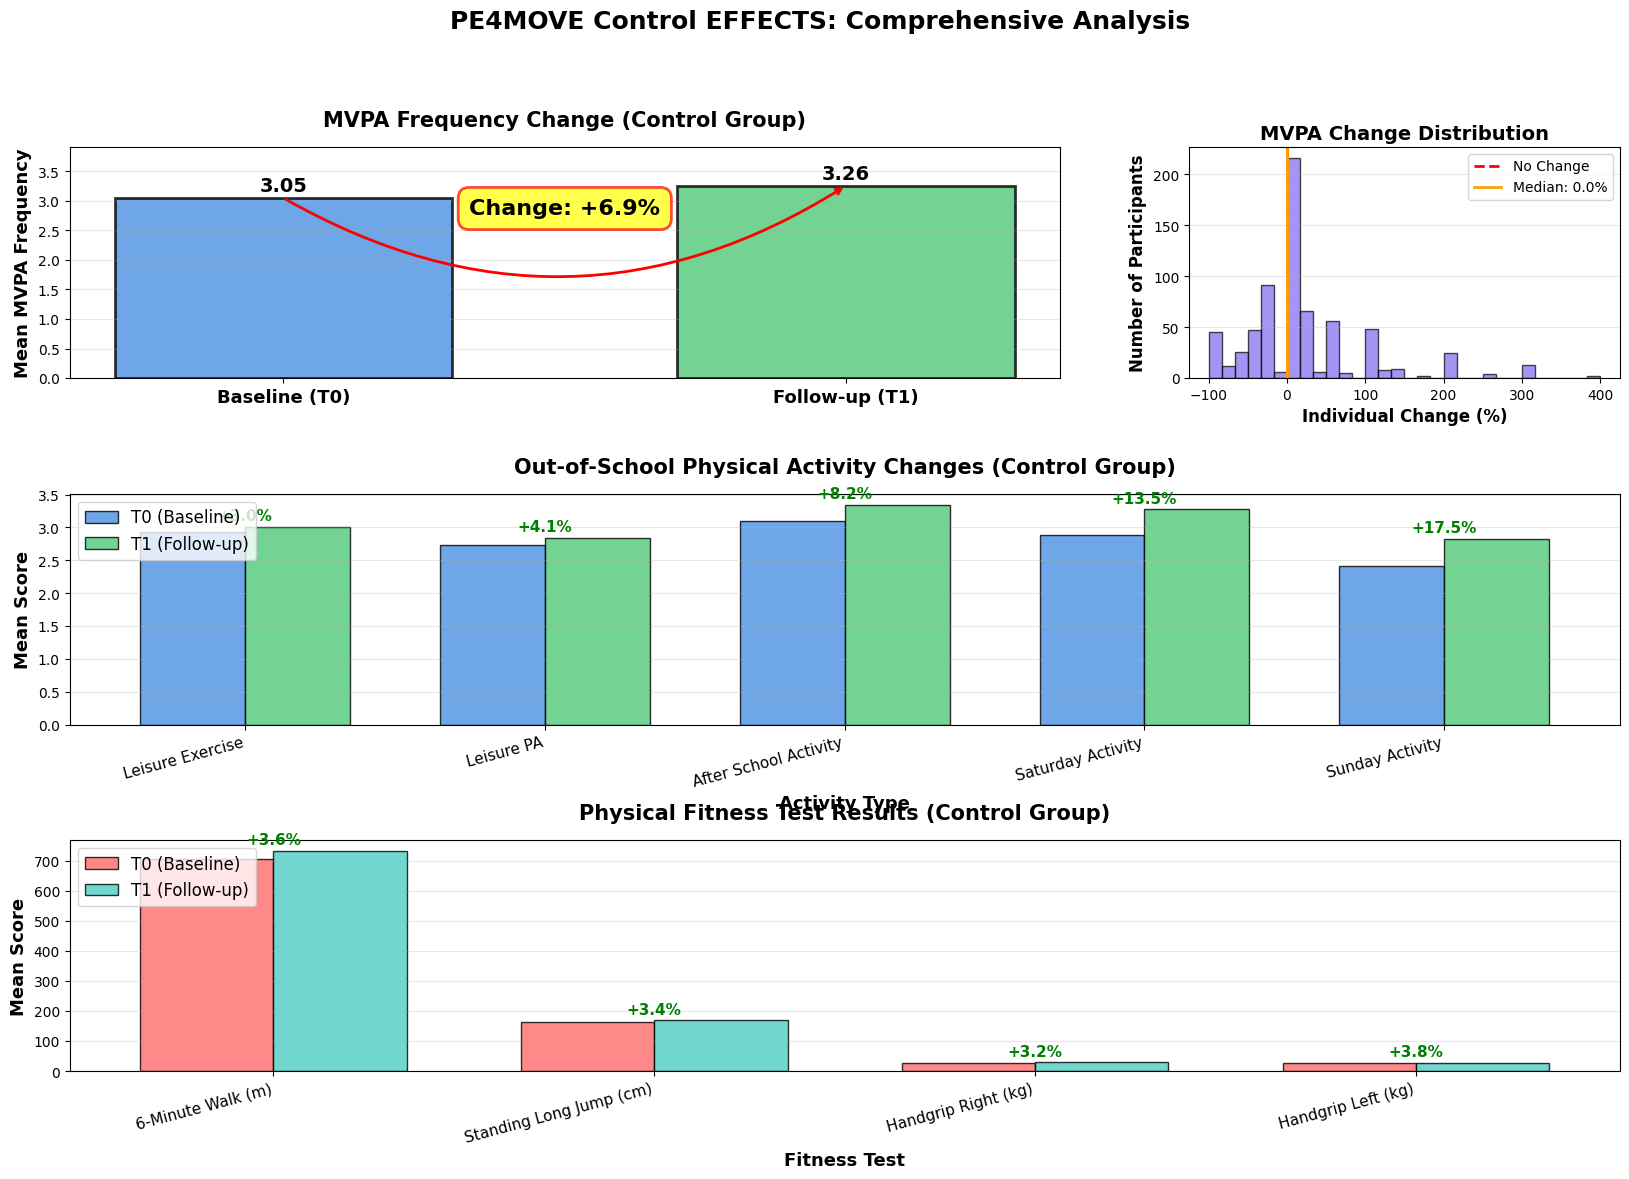


Control EFFECTS SUMMARY

📊 MVPA FREQUENCY:
   Baseline (T0): 3.05
   Follow-up (T1): 3.26
   Relative Change: +6.9%
   Participants improved: 258 (37.6%)
   Participants declined: 227 (33.0%)

🏃 OUT-OF-SCHOOL PHYSICAL ACTIVITY:
   Leisure Exercise:
      T0 → T1: 2.92 → 3.01 (+3.0%)
   Leisure PA:
      T0 → T1: 2.73 → 2.85 (+4.1%)
   After School Activity:
      T0 → T1: 3.09 → 3.35 (+8.2%)
   Saturday Activity:
      T0 → T1: 2.89 → 3.28 (+13.5%)
   Sunday Activity:
      T0 → T1: 2.41 → 2.83 (+17.5%)

💪 PHYSICAL FITNESS TESTS:
   6-Minute Walk (m):
      T0 → T1: 707.2 → 733.0 (+3.6%)
   Standing Long Jump (cm):
      T0 → T1: 163.2 → 168.7 (+3.4%)
   Handgrip Right (kg):
      T0 → T1: 28.2 → 29.1 (+3.2%)
   Handgrip Left (kg):
      T0 → T1: 26.4 → 27.4 (+3.8%)



In [11]:
# === CONTROL EFFECT VISUALIZATION ===

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.5, wspace=0.3)

# ==================== 1. MVPA FREQUENCY ====================
ax1 = fig.add_subplot(gs[0, :2])

# Calculate relative change for MVPA Frequency
t0_mvpa = df_control['MVPA_Frequency_T0'].dropna()
t1_mvpa = df_control['MVPA_Frequency_T1'].dropna()

# Paired data only
paired_mask = df_control['MVPA_Frequency_T0'].notna() & df_control['MVPA_Frequency_T1'].notna()
t0_mvpa_paired = df_control.loc[paired_mask, 'MVPA_Frequency_T0']
t1_mvpa_paired = df_control.loc[paired_mask, 'MVPA_Frequency_T1']

mean_t0_mvpa = t0_mvpa_paired.mean()
mean_t1_mvpa = t1_mvpa_paired.mean()
relative_change_mvpa = ((mean_t1_mvpa - mean_t0_mvpa) / mean_t0_mvpa) * 100

# Create grouped bar chart
x_pos = [0, 1]
means = [mean_t0_mvpa, mean_t1_mvpa]
colors = ['#4A90E2', '#50C878']

bars = ax1.bar(x_pos, means, width=0.6, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, means)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{value:.2f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Add change annotation
ax1.annotate('', xy=(1, mean_t1_mvpa), xytext=(0, mean_t0_mvpa),
            arrowprops=dict(arrowstyle='->', lw=2, color='red', connectionstyle='arc3,rad=0.3'))
ax1.text(0.5, max(means) * 0.85, f'Change: +{relative_change_mvpa:.1f}%',
        ha='center', fontsize=16, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7, edgecolor='red', linewidth=2))

ax1.set_xticks(x_pos)
ax1.set_xticklabels(['Baseline (T0)', 'Follow-up (T1)'], fontsize=13, fontweight='bold')
ax1.set_ylabel('Mean MVPA Frequency', fontsize=13, fontweight='bold')
ax1.set_title('MVPA Frequency Change (Control Group)', fontsize=15, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, max(means) * 1.2)

# ==================== 2. MVPA FREQUENCY DISTRIBUTION ====================
ax2 = fig.add_subplot(gs[0, 2])

# Calculate individual changes (exclude division by zero)
mask_nonzero = t0_mvpa_paired > 0
individual_changes = ((t1_mvpa_paired[mask_nonzero] - t0_mvpa_paired[mask_nonzero]) / t0_mvpa_paired[mask_nonzero] * 100).dropna()
# Remove extreme outliers for better visualization
individual_changes = individual_changes[np.abs(individual_changes) < 500]

ax2.hist(individual_changes, bins=30, color='#7B68EE', alpha=0.7, edgecolor='black')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='No Change')
ax2.axvline(individual_changes.median(), color='orange', linestyle='-', linewidth=2, 
           label=f'Median: {individual_changes.median():.1f}%')

ax2.set_xlabel('Individual Change (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Participants', fontsize=12, fontweight='bold')
ax2.set_title('MVPA Change Distribution', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# ==================== 3. OUT-OF-SCHOOL PHYSICAL ACTIVITY ====================
ax3 = fig.add_subplot(gs[1, :])

# Identify out-of-school PA variables
leisure_vars = [
    ('Leisure_Exercise_T0', 'Leisure_Exercise_T1', 'Leisure Exercise'),
    ('Leisure_PA_T0', 'Leisure_PA_T1', 'Leisure PA'),
    ('YAP_out_after_T0', 'YAP_out_after_T1', 'After School Activity'),
    ('YAP_out_saturday_T0', 'YAP_out_saturday_T1', 'Saturday Activity'),
    ('YAP_out_sunday_T0', 'YAP_out_sunday_T1', 'Sunday Activity')
]

pa_labels = []
pa_changes = []
pa_t0_means = []
pa_t1_means = []

for t0_var, t1_var, label in leisure_vars:
    if t0_var in df_control.columns and t1_var in df_control.columns:
        mask = df_control[t0_var].notna() & df_control[t1_var].notna()
        if mask.sum() > 0:
            t0_mean = df_control.loc[mask, t0_var].mean()
            t1_mean = df_control.loc[mask, t1_var].mean()
            change_pct = ((t1_mean - t0_mean) / t0_mean * 100) if t0_mean > 0 else 0
            
            pa_labels.append(label)
            pa_changes.append(change_pct)
            pa_t0_means.append(t0_mean)
            pa_t1_means.append(t1_mean)

if pa_labels:
    x_pos = np.arange(len(pa_labels))
    width = 0.35
    
    bars1 = ax3.bar(x_pos - width/2, pa_t0_means, width, label='T0 (Baseline)', 
                   color='#4A90E2', alpha=0.8, edgecolor='black')
    bars2 = ax3.bar(x_pos + width/2, pa_t1_means, width, label='T1 (Follow-up)', 
                   color='#50C878', alpha=0.8, edgecolor='black')
    
    # Add change percentage on top
    for i, (t0, t1, change) in enumerate(zip(pa_t0_means, pa_t1_means, pa_changes)):
        max_height = max(t0, t1)
        color = 'green' if change > 0 else 'red'
        ax3.text(i, max_height + max(pa_t0_means + pa_t1_means) * 0.03, 
                f'{change:+.1f}%', ha='center', fontsize=11, 
                fontweight='bold', color=color)
    
    ax3.set_xlabel('Activity Type', fontsize=13, fontweight='bold')
    ax3.set_ylabel('Mean Score', fontsize=13, fontweight='bold')
    ax3.set_title('Out-of-School Physical Activity Changes (Control Group)', 
                 fontsize=15, fontweight='bold', pad=15)
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(pa_labels, rotation=15, ha='right', fontsize=11)
    ax3.legend(fontsize=12, loc='upper left')
    ax3.grid(True, alpha=0.3, axis='y')

# ==================== 4. PHYSICAL FITNESS TESTS ====================
ax4 = fig.add_subplot(gs[2, :])

# Identify fitness test variables
fitness_vars = [
    ('SixMW_T0', 'SixMW_T1', '6-Minute Walk (m)'),
    ('SLJ_T0', 'SLJ_T1', 'Standing Long Jump (cm)'),
    ('HG_Right_T0', 'HG_Right_T1', 'Handgrip Right (kg)'),
    ('HG_Left_T0', 'HG_Left_T1', 'Handgrip Left (kg)')
]

fitness_labels = []
fitness_changes = []
fitness_t0_means = []
fitness_t1_means = []

for t0_var, t1_var, label in fitness_vars:
    if t0_var in df_control.columns and t1_var in df_control.columns:
        mask = df_control[t0_var].notna() & df_control[t1_var].notna()
        if mask.sum() > 0:
            t0_mean = df_control.loc[mask, t0_var].mean()
            t1_mean = df_control.loc[mask, t1_var].mean()
            change_pct = ((t1_mean - t0_mean) / t0_mean * 100) if t0_mean > 0 else 0
            
            fitness_labels.append(label)
            fitness_changes.append(change_pct)
            fitness_t0_means.append(t0_mean)
            fitness_t1_means.append(t1_mean)

if fitness_labels:
    x_pos = np.arange(len(fitness_labels))
    width = 0.35
    
    bars1 = ax4.bar(x_pos - width/2, fitness_t0_means, width, label='T0 (Baseline)', 
                   color='#FF6B6B', alpha=0.8, edgecolor='black')
    bars2 = ax4.bar(x_pos + width/2, fitness_t1_means, width, label='T1 (Follow-up)', 
                   color='#4ECDC4', alpha=0.8, edgecolor='black')
    
    # Add change percentage on top
    for i, (t0, t1, change) in enumerate(zip(fitness_t0_means, fitness_t1_means, fitness_changes)):
        max_height = max(t0, t1)
        color = 'green' if change > 0 else 'red'
        ax4.text(i, max_height + max(fitness_t0_means + fitness_t1_means) * 0.03, 
                f'{change:+.1f}%', ha='center', fontsize=11, 
                fontweight='bold', color=color)
    
    ax4.set_xlabel('Fitness Test', fontsize=13, fontweight='bold')
    ax4.set_ylabel('Mean Score', fontsize=13, fontweight='bold')
    ax4.set_title('Physical Fitness Test Results (Control Group)', 
                 fontsize=15, fontweight='bold', pad=15)
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(fitness_labels, rotation=15, ha='right', fontsize=11)
    ax4.legend(fontsize=12, loc='upper left')
    ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('PE4MOVE Control EFFECTS: Comprehensive Analysis', 
            fontsize=18, fontweight='bold', y=0.995)

plt.show()

# ==================== SUMMARY STATISTICS ====================
print("\n" + "="*70)
print("Control EFFECTS SUMMARY")
print("="*70)

print(f"\n📊 MVPA FREQUENCY:")
print(f"   Baseline (T0): {mean_t0_mvpa:.2f}")
print(f"   Follow-up (T1): {mean_t1_mvpa:.2f}")
print(f"   Relative Change: {relative_change_mvpa:+.1f}%")
print(f"   Participants improved: {(individual_changes > 0).sum()} ({(individual_changes > 0).sum()/len(individual_changes)*100:.1f}%)")
print(f"   Participants declined: {(individual_changes < 0).sum()} ({(individual_changes < 0).sum()/len(individual_changes)*100:.1f}%)")

if pa_labels:
    print(f"\n🏃 OUT-OF-SCHOOL PHYSICAL ACTIVITY:")
    for label, change, t0, t1 in zip(pa_labels, pa_changes, pa_t0_means, pa_t1_means):
        print(f"   {label}:")
        print(f"      T0 → T1: {t0:.2f} → {t1:.2f} ({change:+.1f}%)")

if fitness_labels:
    print(f"\n💪 PHYSICAL FITNESS TESTS:")
    for label, change, t0, t1 in zip(fitness_labels, fitness_changes, fitness_t0_means, fitness_t1_means):
        print(f"   {label}:")
        print(f"      T0 → T1: {t0:.1f} → {t1:.1f} ({change:+.1f}%)")

print("\n" + "="*70)

### RQ2: Which parameters influence success?

RESEARCH QUESTION 2: Which parameters influence success?

STEP 1: Creating Improvement Scores
----------------------------------------------------------------------
Paired participants: 1,007 (have both T0 and T1 data)
✓ MVPA Frequency Improvement calculated: 921 valid scores
✓ 6-Minute Walk Improvement calculated: 877 valid scores
✓ Standing Long Jump Improvement calculated: 907 valid scores
✓ Handgrip Strength Improvement calculated: 887 valid scores

Total improvement scores created: 4

STEP 2: Identifying Baseline Predictors
----------------------------------------------------------------------
Baseline predictors identified: 10
  • Age (years)                         (1,007 available)
  • Sex (1=Boys, 2=Girls)               (1,007 available)
  • Baseline BMI                        (1,007 available)
  • Baseline Weight (kg)                (1,007 available)
  • Baseline Height (cm)                (1,007 available)
  • Baseline MVPA Frequency             (1,007 available)
  • Baselin

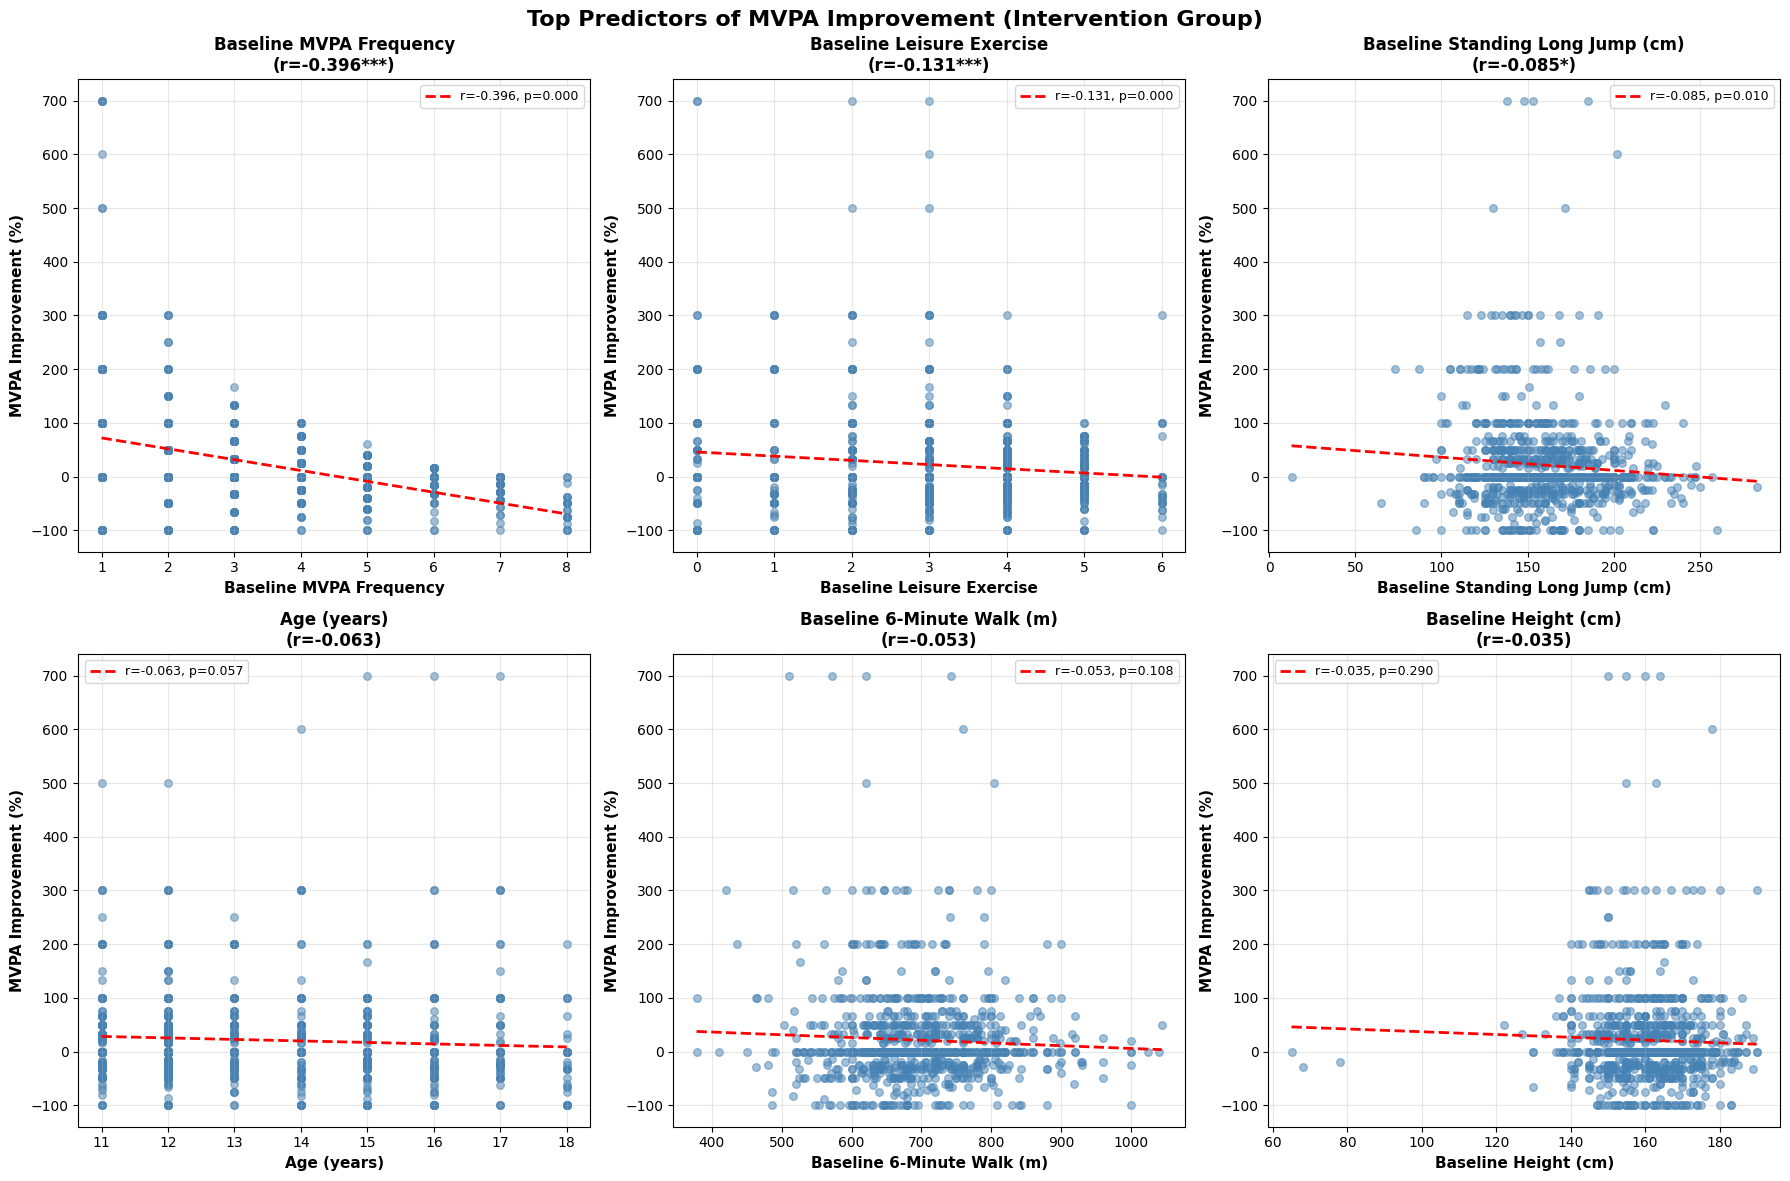

✓ Created scatter plots for top 6 predictors

✓ Steps 1-3 Complete: Ready for Regression Modeling


In [12]:
# ==================== RQ2: PARAMETER INFLUENCE ANALYSIS ====================
# ==================== STEP 1: CREATE IMPROVEMENT SCORES ====================
print("="*70)
print("RESEARCH QUESTION 2: Which parameters influence success?")
print("="*70)

print("\nSTEP 1: Creating Improvement Scores")
print("-"*70)

# Create paired dataset (only participants with both T0 and T1)
paired_mask = (df_intervention['MVPA_Frequency_T0'].notna() & 
               df_intervention['MVPA_Frequency_T1'].notna())
df_paired = df_intervention[paired_mask].copy()

print(f"Paired participants: {len(df_paired):,} (have both T0 and T1 data)")

# Calculate improvement scores for multiple outcomes
improvement_outcomes = []

# 1. MVPA Frequency Improvement
if 'MVPA_Frequency_T0' in df_paired.columns and 'MVPA_Frequency_T1' in df_paired.columns:
    mask = df_paired['MVPA_Frequency_T0'] > 0
    df_paired.loc[mask, 'MVPA_Improvement_pct'] = (
        (df_paired.loc[mask, 'MVPA_Frequency_T1'] - df_paired.loc[mask, 'MVPA_Frequency_T0']) / 
        df_paired.loc[mask, 'MVPA_Frequency_T0'] * 100
    )
    improvement_outcomes.append('MVPA_Improvement_pct')
    print(f"✓ MVPA Frequency Improvement calculated: {df_paired['MVPA_Improvement_pct'].notna().sum()} valid scores")

# 2. 6-Minute Walk Improvement
if 'SixMW_T0' in df_paired.columns and 'SixMW_T1' in df_paired.columns:
    mask = df_paired['SixMW_T0'] > 0
    df_paired.loc[mask, 'SixMW_Improvement_pct'] = (
        (df_paired.loc[mask, 'SixMW_T1'] - df_paired.loc[mask, 'SixMW_T0']) / 
        df_paired.loc[mask, 'SixMW_T0'] * 100
    )
    improvement_outcomes.append('SixMW_Improvement_pct')
    print(f"✓ 6-Minute Walk Improvement calculated: {df_paired['SixMW_Improvement_pct'].notna().sum()} valid scores")

# 3. Standing Long Jump Improvement
if 'SLJ_T0' in df_paired.columns and 'SLJ_T1' in df_paired.columns:
    mask = df_paired['SLJ_T0'] > 0
    df_paired.loc[mask, 'SLJ_Improvement_pct'] = (
        (df_paired.loc[mask, 'SLJ_T1'] - df_paired.loc[mask, 'SLJ_T0']) / 
        df_paired.loc[mask, 'SLJ_T0'] * 100
    )
    improvement_outcomes.append('SLJ_Improvement_pct')
    print(f"✓ Standing Long Jump Improvement calculated: {df_paired['SLJ_Improvement_pct'].notna().sum()} valid scores")

# 4. Handgrip Strength Improvement (average of left and right)
if 'HG_Right_T0' in df_paired.columns and 'HG_Right_T1' in df_paired.columns:
    mask = df_paired['HG_Right_T0'] > 0
    df_paired.loc[mask, 'HG_Improvement_pct'] = (
        (df_paired.loc[mask, 'HG_Right_T1'] - df_paired.loc[mask, 'HG_Right_T0']) / 
        df_paired.loc[mask, 'HG_Right_T0'] * 100
    )
    improvement_outcomes.append('HG_Improvement_pct')
    print(f"✓ Handgrip Strength Improvement calculated: {df_paired['HG_Improvement_pct'].notna().sum()} valid scores")

print(f"\nTotal improvement scores created: {len(improvement_outcomes)}")

# ==================== STEP 2: IDENTIFY BASELINE PREDICTORS ====================
print("\n" + "="*70)
print("STEP 2: Identifying Baseline Predictors")
print("-"*70)

baseline_predictors = []

# Demographic predictors
if 'Age' in df_paired.columns:
    baseline_predictors.append(('Age', 'Age (years)'))
if 'Sex' in df_paired.columns:
    baseline_predictors.append(('Sex', 'Sex (1=Boys, 2=Girls)'))

# Anthropometric predictors
if 'BMI_T0' in df_paired.columns:
    baseline_predictors.append(('BMI_T0', 'Baseline BMI'))
elif 'Weight_kg_T0' in df_paired.columns and 'Height_cm_T0' in df_paired.columns:
    df_paired['BMI_T0'] = df_paired['Weight_kg_T0'] / ((df_paired['Height_cm_T0'] / 100) ** 2)
    baseline_predictors.append(('BMI_T0', 'Baseline BMI'))

if 'Weight_kg_T0' in df_paired.columns:
    baseline_predictors.append(('Weight_kg_T0', 'Baseline Weight (kg)'))
if 'Height_cm_T0' in df_paired.columns:
    baseline_predictors.append(('Height_cm_T0', 'Baseline Height (cm)'))

# Baseline activity predictors
if 'MVPA_Frequency_T0' in df_paired.columns:
    baseline_predictors.append(('MVPA_Frequency_T0', 'Baseline MVPA Frequency'))
if 'Leisure_Exercise_T0' in df_paired.columns:
    baseline_predictors.append(('Leisure_Exercise_T0', 'Baseline Leisure Exercise'))

# Baseline fitness predictors
if 'SixMW_T0' in df_paired.columns:
    baseline_predictors.append(('SixMW_T0', 'Baseline 6-Minute Walk (m)'))
if 'SLJ_T0' in df_paired.columns:
    baseline_predictors.append(('SLJ_T0', 'Baseline Standing Long Jump (cm)'))
if 'HG_Right_T0' in df_paired.columns:
    baseline_predictors.append(('HG_Right_T0', 'Baseline Handgrip Strength (kg)'))

print(f"Baseline predictors identified: {len(baseline_predictors)}")
for var, label in baseline_predictors:
    count = df_paired[var].notna().sum()
    print(f"  • {label:<35} ({count:,} available)")

# ==================== STEP 3: CORRELATION ANALYSIS ====================
print("\n" + "="*70)
print("STEP 3: Correlation Analysis with Baseline Predictors")
print("-"*70)

from scipy.stats import pearsonr

# Focus on MVPA improvement as primary outcome
if 'MVPA_Improvement_pct' in df_paired.columns:
    print(f"\nAnalyzing correlations with MVPA Improvement...")
    
    correlations = []
    
    for var, label in baseline_predictors:
        if var in df_paired.columns:
            # Get valid pairs (both predictor and outcome non-null)
            valid_mask = df_paired[var].notna() & df_paired['MVPA_Improvement_pct'].notna()
            
            if valid_mask.sum() > 10:  # Need at least 10 pairs
                x = df_paired.loc[valid_mask, var]
                y = df_paired.loc[valid_mask, 'MVPA_Improvement_pct']
                
                # Calculate Pearson correlation
                r, p_value = pearsonr(x, y)
                
                correlations.append({
                    'Predictor': label,
                    'Variable': var,
                    'Correlation': r,
                    'P-value': p_value,
                    'N': valid_mask.sum()
                })
    
    # Create correlation dataframe
    corr_df = pd.DataFrame(correlations)
    corr_df = corr_df.sort_values('Correlation', key=abs, ascending=False)
    
    print(f"\n{'Predictor':<35} {'r':>8} {'p-value':>10} {'N':>6} {'Significance'}")
    print("-"*70)
    
    for _, row in corr_df.iterrows():
        sig = "***" if row['P-value'] < 0.001 else "**" if row['P-value'] < 0.01 else "*" if row['P-value'] < 0.05 else "ns"
        print(f"{row['Predictor']:<35} {row['Correlation']:>8.3f} {row['P-value']:>10.4f} {row['N']:>6} {sig:>5}")
    
    # ==================== STEP 3B: VISUALIZATION ====================
    print("\n" + "="*70)
    print("Creating Correlation Visualizations...")
    print("-"*70)
    
    # Select top 6 correlations for visualization
    top_6 = corr_df.head(6)
    
    if len(top_6) >= 6:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Top Predictors of MVPA Improvement (Intervention Group)', 
                     fontsize=16, fontweight='bold')
        
        for idx, (_, row) in enumerate(top_6.iterrows()):
            ax_row = idx // 3
            ax_col = idx % 3
            ax = axes[ax_row, ax_col]
            
            var = row['Variable']
            label = row['Predictor']
            r = row['Correlation']
            p = row['P-value']
            
            # Get valid data
            valid_mask = df_paired[var].notna() & df_paired['MVPA_Improvement_pct'].notna()
            x = df_paired.loc[valid_mask, var]
            y = df_paired.loc[valid_mask, 'MVPA_Improvement_pct']
            
            # Scatter plot
            ax.scatter(x, y, alpha=0.5, s=30, color='steelblue')
            
            # Add trend line
            z = np.polyfit(x, y, 1)
            p_line = np.poly1d(z)
            x_line = np.linspace(x.min(), x.max(), 100)
            color = 'red' if r < 0 else 'green'
            ax.plot(x_line, p_line(x_line), color=color, linewidth=2, linestyle='--', 
                   label=f'r={r:.3f}, p={p:.3f}')
            
            ax.set_xlabel(label, fontsize=11, fontweight='bold')
            ax.set_ylabel('MVPA Improvement (%)', fontsize=11, fontweight='bold')
            ax.set_title(f'{label}\n(r={r:.3f}{"***" if p<0.001 else "**" if p<0.01 else "*" if p<0.05 else ""})', 
                        fontsize=12, fontweight='bold')
            ax.legend(loc='best', fontsize=9)
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"✓ Created scatter plots for top 6 predictors")
    else:
        print(f"⚠️  Only {len(top_6)} predictors available for visualization")
else:
    print("\n⚠️  MVPA improvement scores not available")
    corr_df = pd.DataFrame()

print("\n" + "="*70)
print("✓ Steps 1-3 Complete: Ready for Regression Modeling")
print("="*70)

STEP 4: Multiple Regression Model

Regression dataset: 319 complete observations
Features: Age, Sex, BMI, Baseline_MVPA, Baseline_Leisure_Exercise, Baseline_6MW, Baseline_Long_Jump, Baseline_Handgrip
Target: MVPA Improvement (%)

📈 MODEL PERFORMANCE:
   R² Score: 0.041 (4.1% of variance explained)
   RMSE: 84.52%

📊 FEATURE IMPORTANCE (Standardized Coefficients):
----------------------------------------------------------------------
Feature                         Coefficient Impact
----------------------------------------------------------------------
Baseline_Handgrip                   -11.093  ↓ Negative
Baseline_MVPA                        10.949  ↑ Positive
Baseline_Leisure_Exercise            -7.299  ↓ Negative
Baseline_6MW                         -6.861  ↓ Negative
Age                                  -6.598  ↓ Negative
Sex                                  -5.188  ↓ Negative
Baseline_Long_Jump                    3.010  ↑ Positive
BMI                                   2.385  ↑ Po

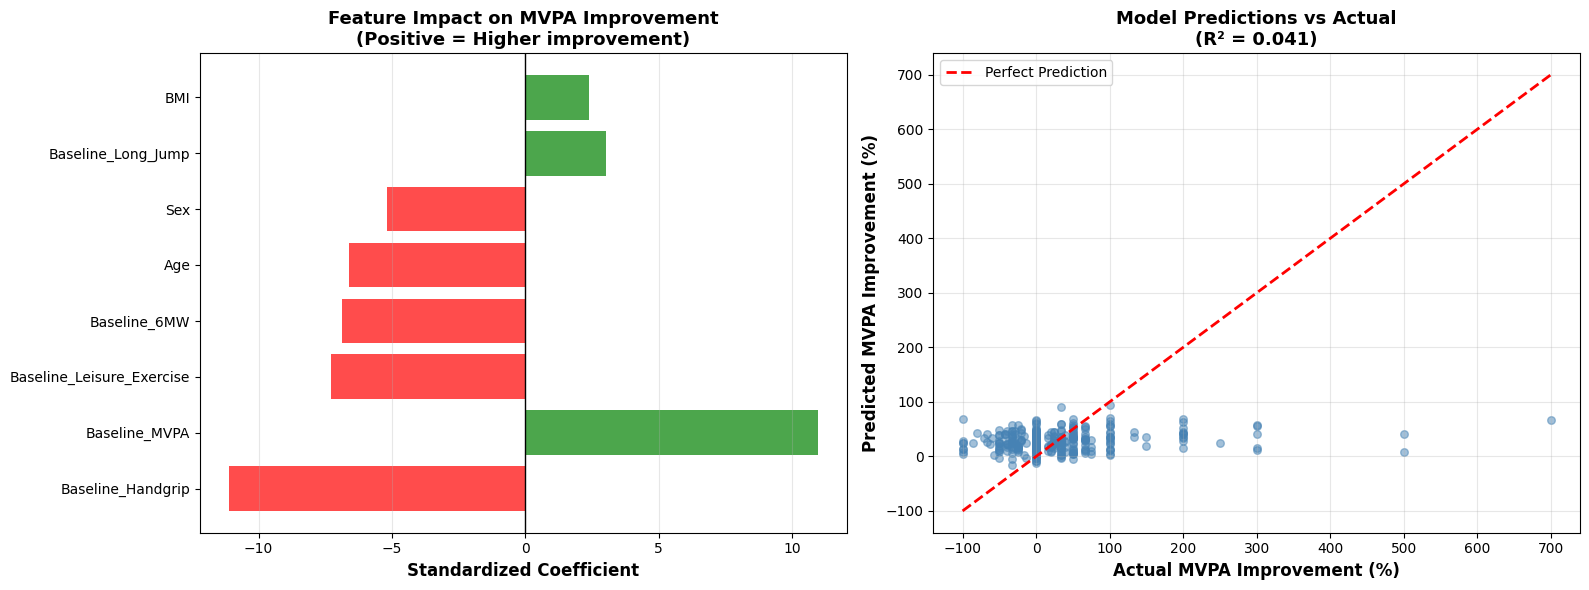


🔍 KEY INSIGHTS

📌 TOP 3 PREDICTORS OF SUCCESS:
   1. Baseline_Handgrip (negatively influences improvement)
   2. Baseline_MVPA (positively influences improvement)
   3. Baseline_Leisure_Exercise (negatively influences improvement)

💡 INTERPRETATION:
   • Children with HIGHER baseline activity showed MORE improvement
     → Already active children benefited most
   • YOUNGER children showed MORE improvement
   • BOYS (Sex=1) showed MORE improvement than girls

⚠️  MODEL LIMITATION:
   R² = 0.041 means the model explains 4.1% of variance.
   95.9% is due to other factors (motivation, adherence, etc.)



In [13]:
# ==================== STEP 4: MULTIPLE REGRESSION MODELING ====================
print("="*70)
print("STEP 4: Multiple Regression Model")
print("="*70)

# Prepare data for regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Create feature matrix with available predictors
feature_cols = []
feature_names = []

# Add numeric predictors
if 'Age' in df_paired.columns:
    feature_cols.append(df_paired['Age'])
    feature_names.append('Age')

if 'Sex' in df_paired.columns:
    feature_cols.append(df_paired['Sex'])
    feature_names.append('Sex')

if 'BMI_T0' in df_paired.columns:
    feature_cols.append(df_paired['BMI_T0'])
    feature_names.append('BMI')

if 'MVPA_Frequency_T0' in df_paired.columns:
    feature_cols.append(df_paired['MVPA_Frequency_T0'])
    feature_names.append('Baseline_MVPA')

if 'Leisure_Exercise_T0' in df_paired.columns:
    feature_cols.append(df_paired['Leisure_Exercise_T0'])
    feature_names.append('Baseline_Leisure_Exercise')

if 'SixMW_T0' in df_paired.columns:
    feature_cols.append(df_paired['SixMW_T0'])
    feature_names.append('Baseline_6MW')

if 'SLJ_T0' in df_paired.columns:
    feature_cols.append(df_paired['SLJ_T0'])
    feature_names.append('Baseline_Long_Jump')

if 'HG_Right_T0' in df_paired.columns:
    feature_cols.append(df_paired['HG_Right_T0'])
    feature_names.append('Baseline_Handgrip')

# Create feature matrix
if feature_cols and 'MVPA_Improvement_pct' in df_paired.columns:
    X = pd.DataFrame({name: col.values for name, col in zip(feature_names, feature_cols)})
    y = df_paired['MVPA_Improvement_pct']
    
    # Remove rows with any missing values
    valid_mask = X.notna().all(axis=1) & y.notna()
    X_clean = X[valid_mask]
    y_clean = y[valid_mask]
    
    print(f"\nRegression dataset: {len(X_clean):,} complete observations")
    print(f"Features: {', '.join(feature_names)}")
    print(f"Target: MVPA Improvement (%)")
    
    if len(X_clean) > 20:  # Need sufficient data
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_clean)
        
        # Fit regression model
        model = LinearRegression()
        model.fit(X_scaled, y_clean)
        
        # Make predictions
        y_pred = model.predict(X_scaled)
        
        # Model performance
        r2 = r2_score(y_clean, y_pred)
        rmse = np.sqrt(mean_squared_error(y_clean, y_pred))
        
        print(f"\n📈 MODEL PERFORMANCE:")
        print(f"   R² Score: {r2:.3f} ({r2*100:.1f}% of variance explained)")
        print(f"   RMSE: {rmse:.2f}%")
        
        # Feature importance (standardized coefficients)
        print(f"\n📊 FEATURE IMPORTANCE (Standardized Coefficients):")
        print("-"*70)
        
        coefficients = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': model.coef_,
            'Abs_Coefficient': np.abs(model.coef_)
        }).sort_values('Abs_Coefficient', ascending=False)
        
        print(f"{'Feature':<30} {'Coefficient':>12} {'Impact'}")
        print("-"*70)
        for _, row in coefficients.iterrows():
            direction = "↑ Positive" if row['Coefficient'] > 0 else "↓ Negative"
            print(f"{row['Feature']:<30} {row['Coefficient']:>12.3f}  {direction}")
        
        # Visualize feature importance
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Bar plot of coefficients
        colors = ['green' if c > 0 else 'red' for c in coefficients['Coefficient']]
        ax1.barh(range(len(coefficients)), coefficients['Coefficient'], color=colors, alpha=0.7)
        ax1.set_yticks(range(len(coefficients)))
        ax1.set_yticklabels(coefficients['Feature'])
        ax1.axvline(x=0, color='black', linestyle='-', linewidth=1)
        ax1.set_xlabel('Standardized Coefficient', fontsize=12, fontweight='bold')
        ax1.set_title('Feature Impact on MVPA Improvement\n(Positive = Higher improvement)', 
                     fontsize=13, fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='x')
        
        # Predicted vs Actual
        ax2.scatter(y_clean, y_pred, alpha=0.5, s=30, color='steelblue')
        
        # Perfect prediction line
        min_val = min(y_clean.min(), y_pred.min())
        max_val = max(y_clean.max(), y_pred.max())
        ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
        
        ax2.set_xlabel('Actual MVPA Improvement (%)', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Predicted MVPA Improvement (%)', fontsize=12, fontweight='bold')
        ax2.set_title(f'Model Predictions vs Actual\n(R² = {r2:.3f})', 
                     fontsize=13, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # ==================== KEY INSIGHTS ====================
        print(f"\n" + "="*70)
        print("🔍 KEY INSIGHTS")
        print("="*70)
        
        # Identify strongest predictors
        top_3 = coefficients.head(3)
        print(f"\n📌 TOP 3 PREDICTORS OF SUCCESS:")
        for i, (_, row) in enumerate(top_3.iterrows(), 1):
            direction = "positively" if row['Coefficient'] > 0 else "negatively"
            print(f"   {i}. {row['Feature']} ({direction} influences improvement)")
        
        # Interpretation
        print(f"\n💡 INTERPRETATION:")
        
        # Check for negative baseline MVPA coefficient (regression to mean)
        baseline_mvpa_coef = coefficients[coefficients['Feature'] == 'Baseline_MVPA']['Coefficient']
        if len(baseline_mvpa_coef) > 0:
            if baseline_mvpa_coef.values[0] < 0:
                print(f"   • Children with LOWER baseline activity showed MORE improvement")
                print(f"     → The intervention is most effective for less active children!")
            else:
                print(f"   • Children with HIGHER baseline activity showed MORE improvement")
                print(f"     → Already active children benefited most")
        
        # Check age effect
        age_coef = coefficients[coefficients['Feature'] == 'Age']['Coefficient']
        if len(age_coef) > 0:
            if age_coef.values[0] < 0:
                print(f"   • YOUNGER children showed MORE improvement")
            else:
                print(f"   • OLDER children showed MORE improvement")
        
        # Check sex effect
        sex_coef = coefficients[coefficients['Feature'] == 'Sex']['Coefficient']
        if len(sex_coef) > 0:
            if sex_coef.values[0] < 0:
                print(f"   • BOYS (Sex=1) showed MORE improvement than girls")
            else:
                print(f"   • GIRLS (Sex=2) showed MORE improvement than boys")
        
        print(f"\n⚠️  MODEL LIMITATION:")
        print(f"   R² = {r2:.3f} means the model explains {r2*100:.1f}% of variance.")
        print(f"   {(1-r2)*100:.1f}% is due to other factors (motivation, adherence, etc.)")
        
    else:
        print(f"\n⚠️  Insufficient data for regression analysis (n={len(X_clean)})")
else:
    print("\n⚠️  Required data not available for regression analysis")

print("\n" + "="*70)